# APS PMDI canister fluorescence

Post processing of X-ray canister fluorescence data with KI and BaSO4.
Third step - take collated scans and use model developed previously to perform signal trapping corrections.
Depends on geometry and position.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 14/03/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Experimental parameters

The angle of the detector is approximately 67 degrees with respect to the beam according to Roger's photo.

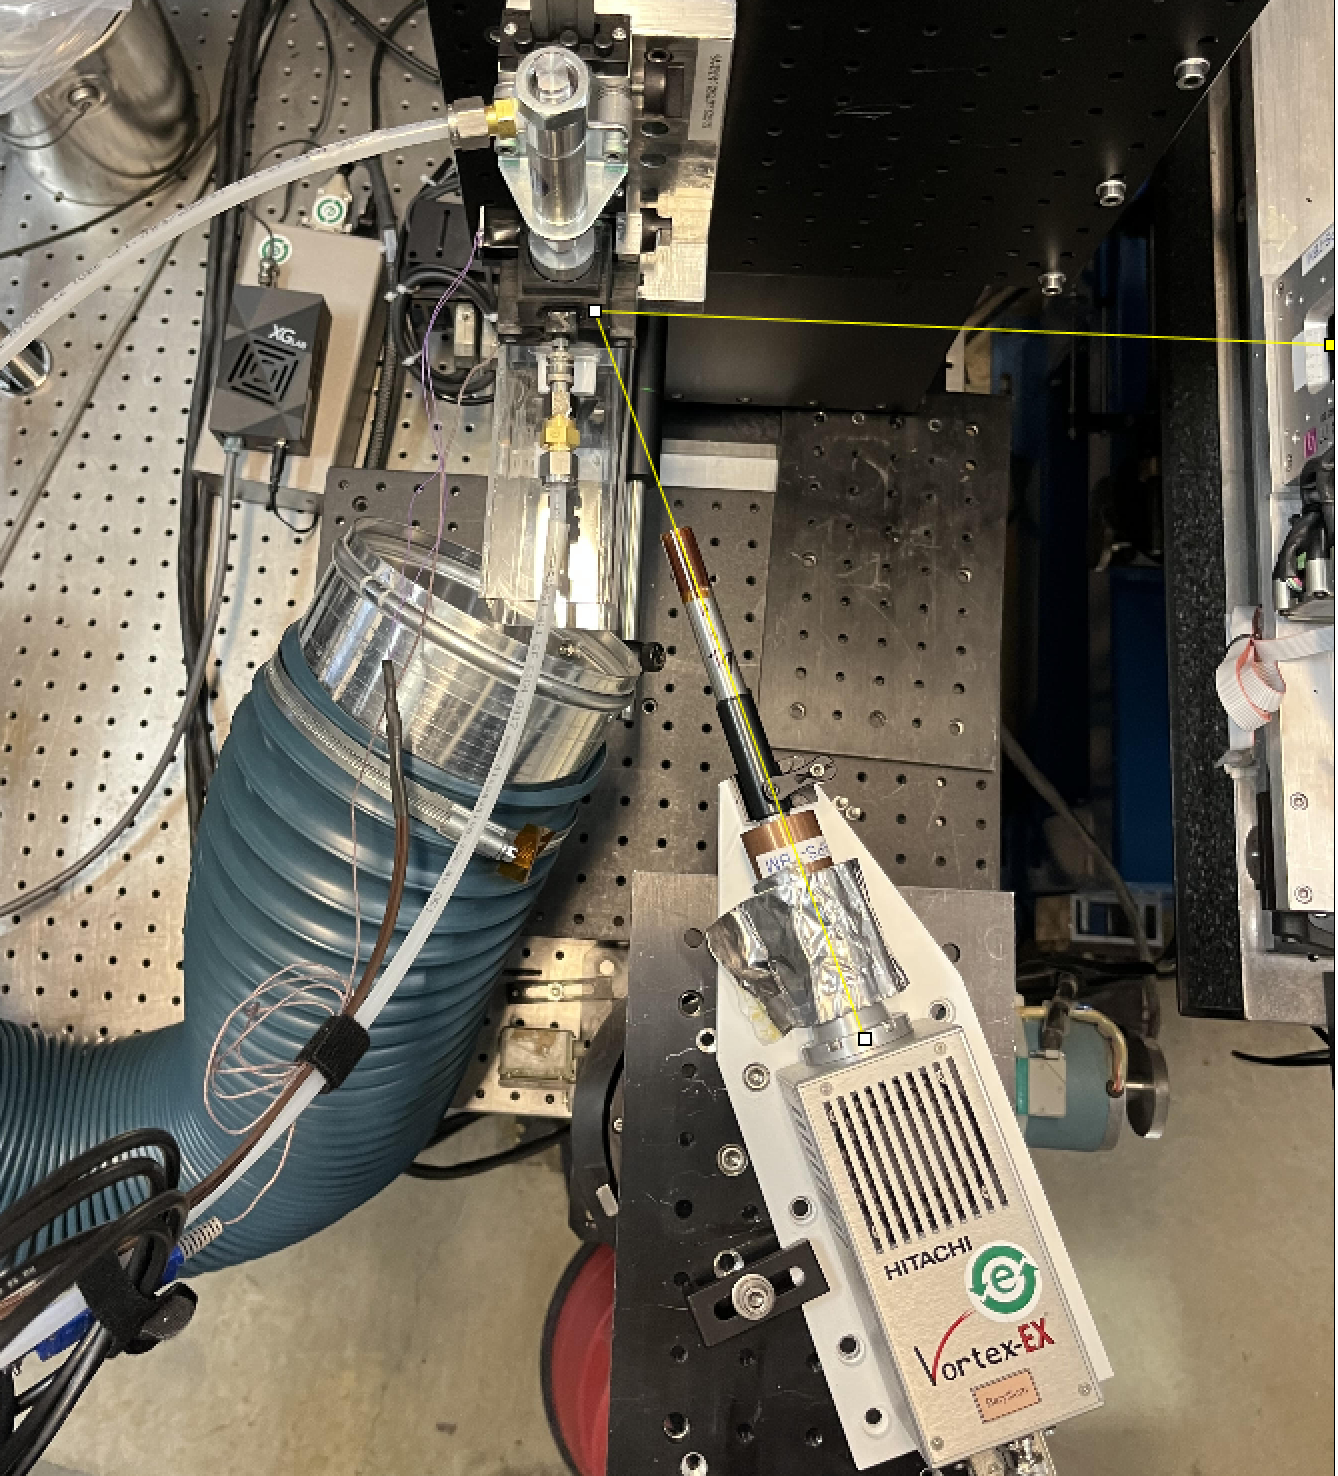

In [55]:
import h5py
import glob
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

# Get my functions from the last notebook, which are saved into a Python module.
from dd_xrf_functions import *

In [2]:
def yTransform(y):
    '''
        Convert the raw beamline Y position to a useful coordinate
        (relative to the valve height).
        
        This was determined based on the dummy scans of an empty can, from the previous notebook
    '''
    return 75-y

## 1. Load an example file with some horizontal scans

First, let's view some uncorrected raw data.

<IPython.core.display.Javascript object>


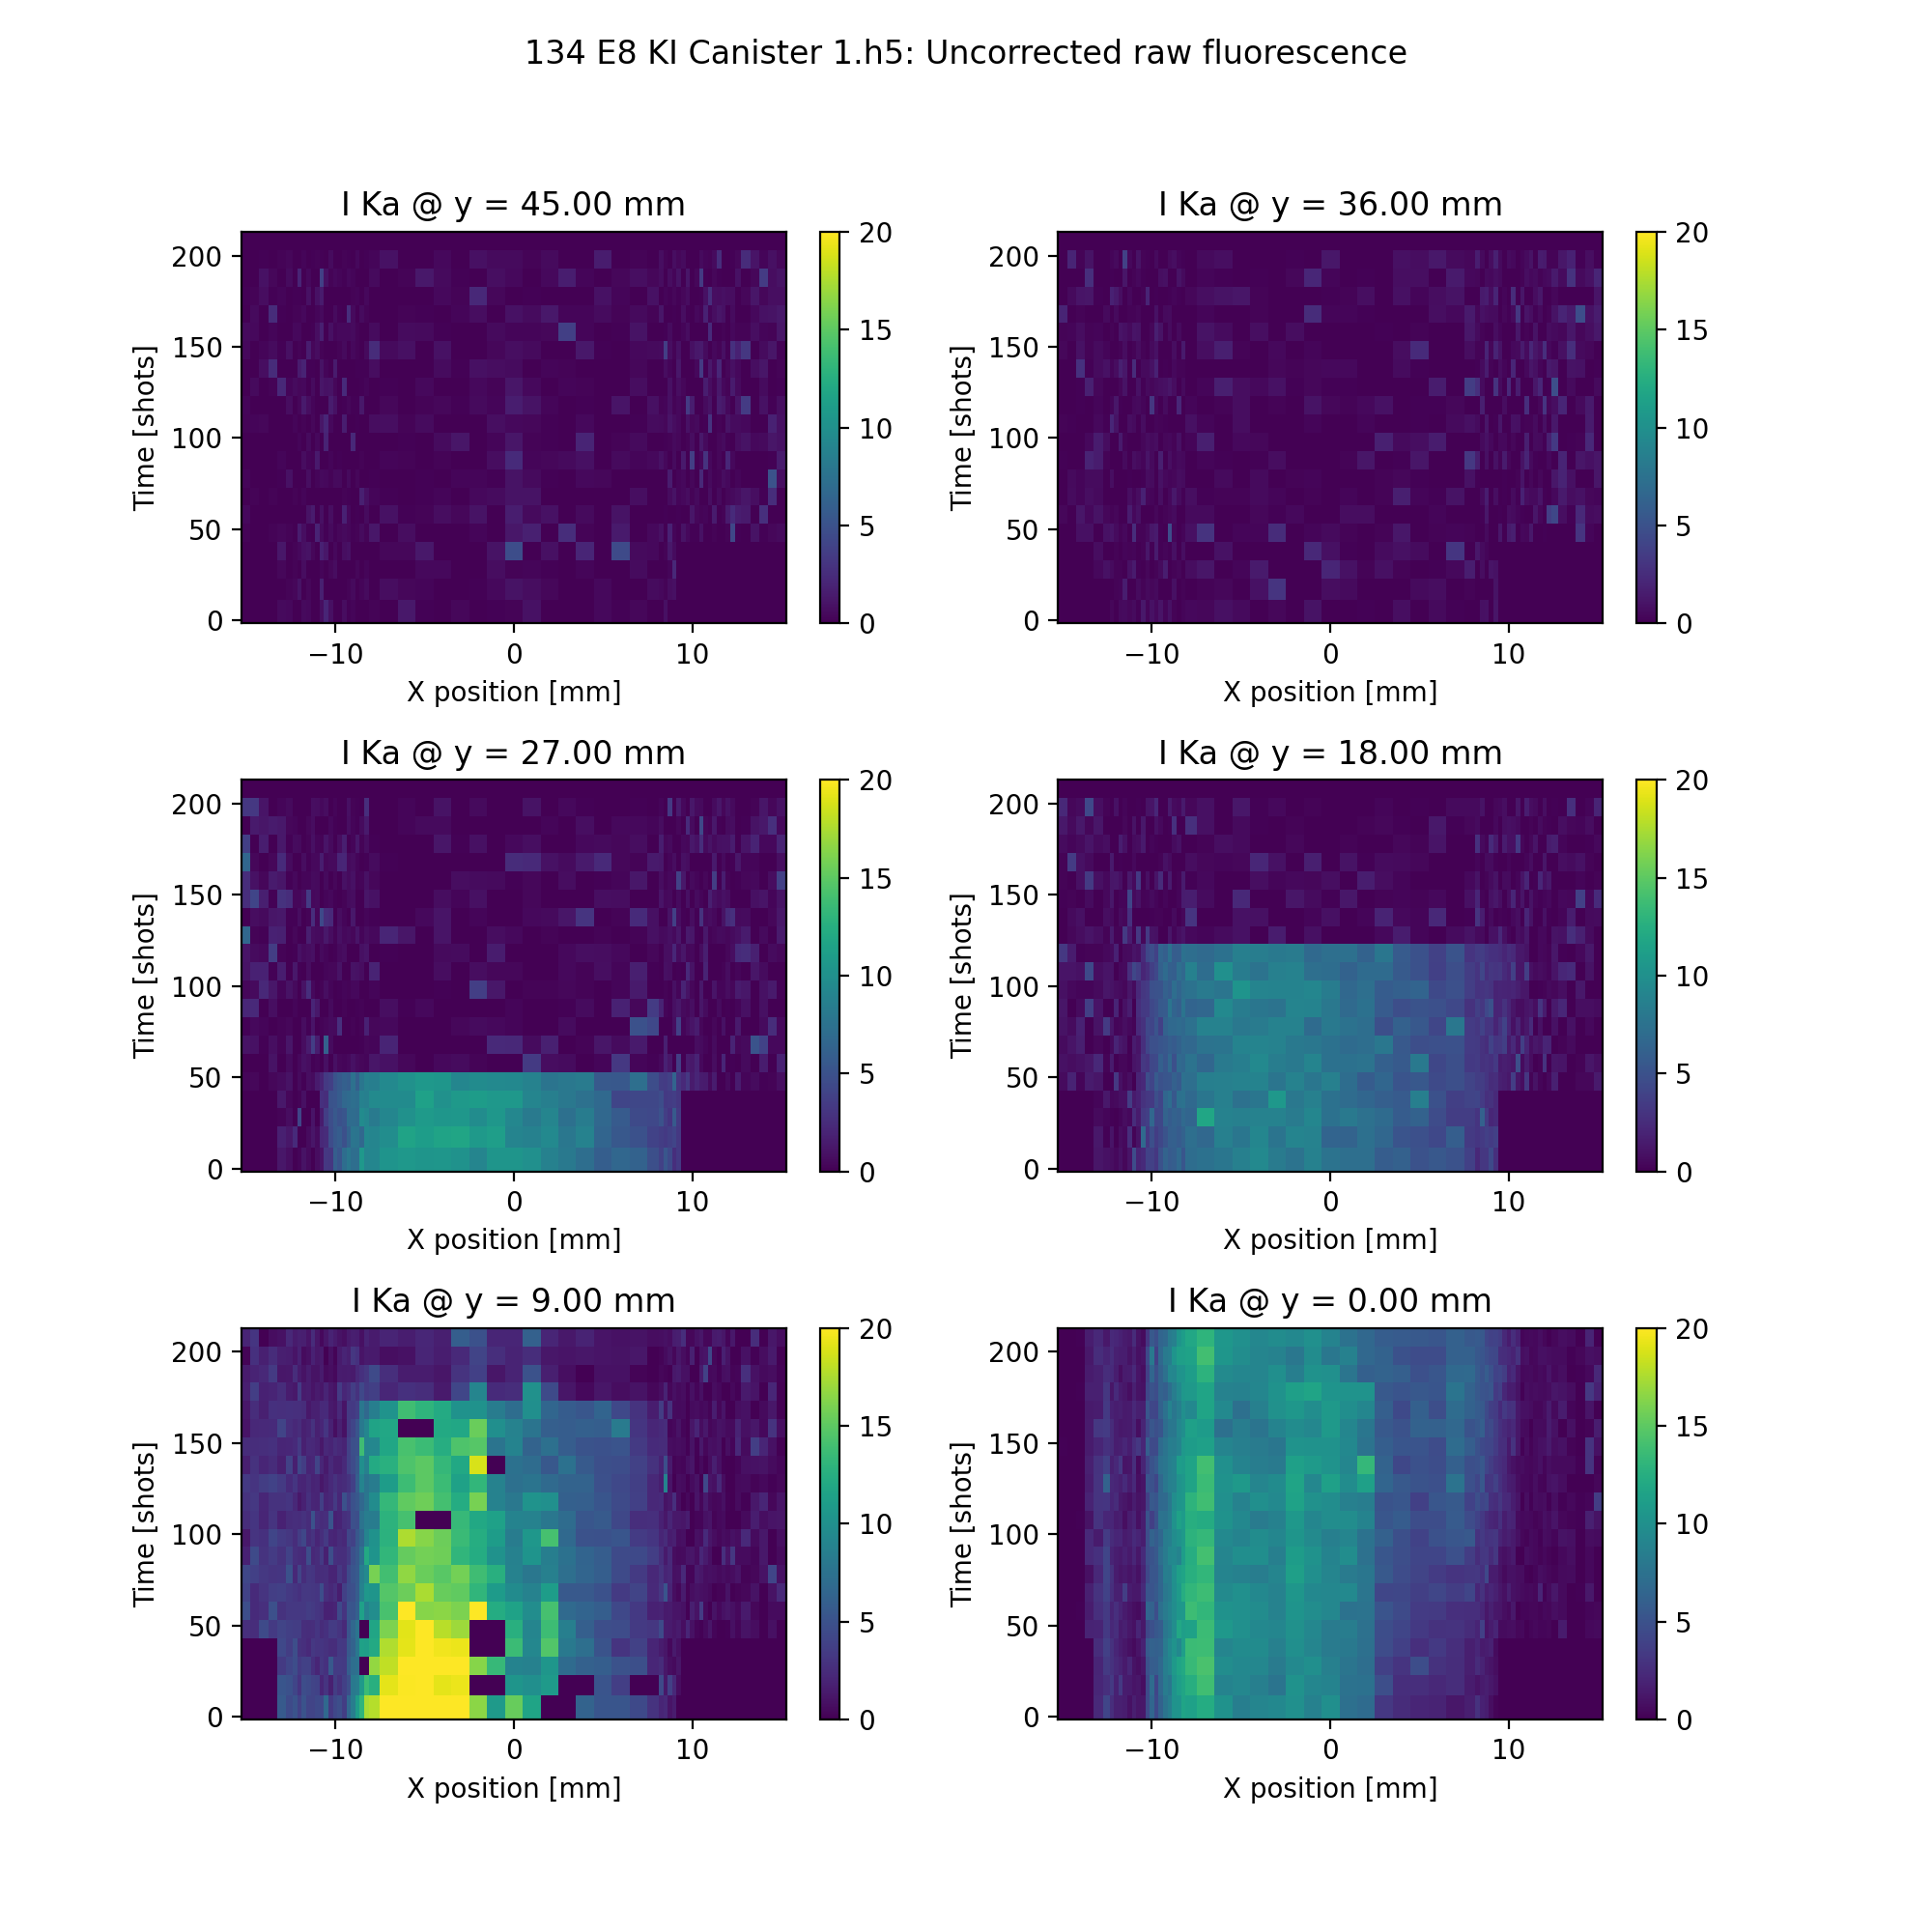

<IPython.core.display.Javascript object>


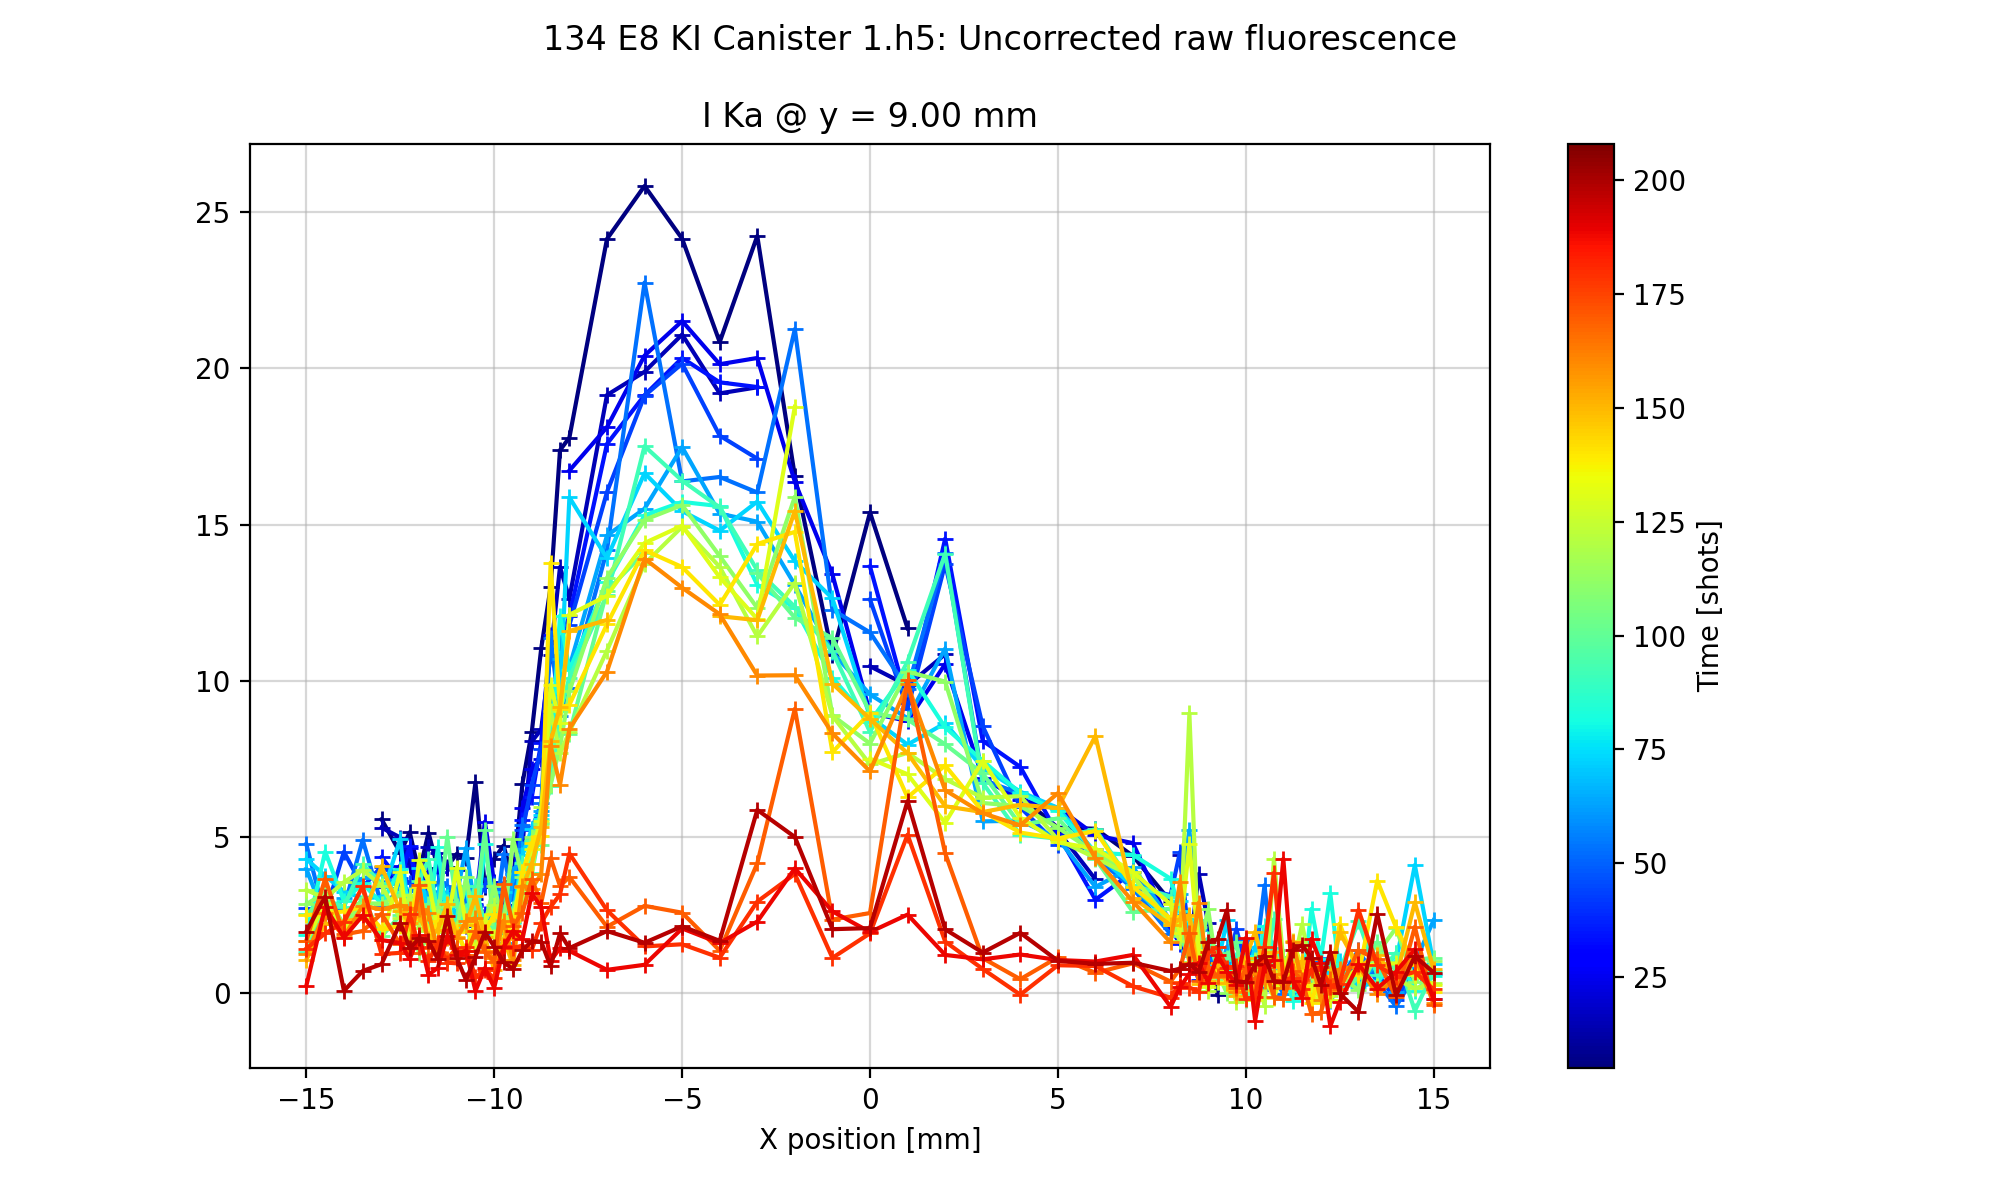

In [3]:
for filename in ["134 E8 KI Canister 1.h5"]:
    
    with h5py.File(filename,'r') as H:
        
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
    
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF[...,i,j]) #/np.diff(x[...,i,j])
                dz = np.hstack((0, dz))
                zF[np.abs(dz)>10,i,j] = np.nan
                
    
        # Plot surfaces of x,t for each y
        fig=plt.figure(figsize=(10,10))
        plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
        for i in range(x.shape[1]):
            ym = np.nanmean(y[:,i,:])
            ax=fig.add_subplot(3,int(x.shape[1]/3),i+1)
            plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
            plt.xlabel('X position [mm]'); plt.ylabel('Time [shots]')
            ph=ax.pcolormesh(x[:,i,:],t[:,i,:],np.nan_to_num(zF[:,i,:]),vmin=0,vmax=20)
            plt.colorbar(ph)
        plt.subplots_adjust(hspace=.4)

        # For a particularly useful position, show some line-plots
        i=4
        ym = np.nanmean(y[:,i,:])
        fig=plt.figure(figsize=(10,6))
        plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
        plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
        plt.grid(alpha=.5)
        for j in range(x.shape[2]): # loop time
            plt.plot(x[:,i,j],zF[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
        plt.xlabel('X position [mm]')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
        plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    

The plot above shows a definite skew to the left hand side, which is almost certainly due to signal-trapping.

## 2. Apply signal trapping corrections to data

Using functions imported from previous notebook.

In [4]:
def canisterWallExtFn(x,x0,ri,thkCan,muCan, thkExtGradient, thkExtConst, muExt, riValve):
    '''
        Calculate absorption through canister wall and rectangular external plastic parts of canister holder
        for transverse co-ordinates x with can aligned at center x0, inner radius ri, wall thickness thk.
        
        Assuming by convention all lengths in mm, and mu is attenuation length in _cm_
    '''
    if (ri<0) | (muCan<0) | (thkExtConst<0) | (muExt<0) | (riValve<0): return 0
    if (np.abs(x0)>5) | (np.abs(thkExtGradient)>5) | (np.abs(thkCan)>1.5) | (riValve>4): return 0
    
    return secantAnnulus(x-x0,ri,ri+thkCan)*muCan*0.1 +\
           secant(x-x0,riValve)*muCan*0.1 +\
           (thkExtGradient*(x-x0) + thkExtConst - secantAnnulus(x-x0,ri,ri+thkCan))*muExt*0.1 

In [5]:
def applySignalTrapping(x_All,y_All,fluor_All,pin_All,I0_All,\
                        propellant = '134',ethMassFrac=0.08, tracer='I', line='a'):
    '''
        Apply signal trapping corrections in the x,z plane. Assuming a cylindrical canister and uniform external environment
        with a uniform internal liquid density (but nonuniform fluorescing tracer concentration possible).
        
        Can handle n-dimensional array data by flattening everything and assessing each sample one at a time.
    '''
        
    # Constants determined by fitting to empty canister data.
    x0=0                 # x-alignment of center of the canister.
    thkCan=0.706982      # canister wall thickness [mm]
    muCan=1.732022       # attenuation/rho of the canister wall at incident beam energy [1/cm]
    muExt=0.455318       # attenuation/rho of the external components 
    
    # Functions that depend on y.
    thkExtGradient = lambda y: 0.2   # attenuation gradient in x of the external environment [1/cm/mm]
    thkExtConst = lambda y: 75.      # attenuation average of the external environment [1/cm]
    ri = lambda y: 10.14               # canister inner wall radius
    riValve = lambda y: 0.           # effective radius of the metering valve or canister dome part [mm]
    
    # X-ray constants
    
    # attenuation/rho of the liquid formulation at the incident energy [1/cm]
    muFluid = {'134':0.328336,'152':0.222837,'1234E':0.271999,'EtOH':0.186543}   
    
    # attenuation/rho of the fluorescing tracer at the incident energy [1/cm]
    muTracer  = {'I':19.4738,'Ba':12.933*137.327/233.38}
    
    # attenuation/rho of the liquid formulation at the emission energy [1/cm]
    muFluid_Ka  = {'I':{'134':0.572199,'152':0.364844,'1234E':0.464389,'EtOH':0.330578},\
                   'Ba':{'134':0.464644,'152':0.30246,'1234E':0.379642,'EtOH':0.289781}}
    
    # attenuation/rho of the canister wall at the emission energy [1/cm]
    muCan_Ka  = {'I':muCan * 3.4816/1.38491,'Ba':muCan * 2.54821/1.38491}
    
    # attenuation/rho of the air at the emission energy [1/cm]
    muAir_Ka  = {'I':0.0004244,'Ba':0.000359733}
    
    # fraction of emission at the chosen K emission line for analysis (a=alpha, b=beta)
    lineYield = {'a':1.54, 'b':0.18} # very similar for both I and Ba
    
    fluorYield = 0.85 # fluorescence yield for this edge.  Very similar for both I and Ba
    
    # Detector constants
    rDet = 275.                        # distance from canister axis to the detector
    thetaDet = 67*np.pi/180.           # angle of the detector with respect to the X axis of the scan.
    thetaDet += 90.
    solidDet = np.pi*(15**2)/(rDet**2) # approximate solid angle of the detector relative to canister axis.
    
    # Calculation fluid mixture absorption, accounting for any density differences.
    muFluidMix = muFluid[propellant]*(1-ethMassFrac) + muFluid['EtOH']*ethMassFrac
    muFluidMix_emission = muFluid_Ka[tracer][propellant]*(1-ethMassFrac) +\
                          muFluid_Ka[tracer]['EtOH']*ethMassFrac
    
    
    # Setup arrays
    x = x_All.ravel() - x0 # shift x positions so canister is in the centre of the coordinate system.
    y = y_All.ravel()
    f = fluor_All.ravel()
    p = pin_All.ravel()
    I0 = I0_All.ravel()
    correction = np.ones_like(x)
    
    # Loop each element in the matrix
    for i in range(len(x)):
        
        # Determine attenuation lengths of incident beam in ext & wall, assuming z-symmetry.
        incidentAbsModel = canisterWallExtFn(x[i],0,ri(y[i]),thkCan,muCan, thkExtGradient(y[i]),\
                                            thkExtConst(y[i]), muExt, riValve(y[i]))
        
        # Determine path length of incident beam thru the fluid in the can. 
        # Missing step here: Assume full instead of using Pin to check full/empty!
        fluidPathLength = secant(x[i],r=ri(y[i]))
    
        # Add the absorption due to the liquid through secant.
        beamAttenuation = incidentAbsModel + fluidPathLength*muFluidMix*0.1
        # 'beamAttenuation' should now be close to the Pin Diode -log(I/I0) value.

        # Take half the incident attenuation and calculate the flux at z=0 by accounting for I0 variation.
        incidentFluxVariation = I0[i]/np.nanmean(I0)
        beamAbsorptionActual = 1 - (p[i]/I0[i])
        fluxAtFocus = np.exp(-beamAttenuation*0.5) * beamAbsorptionActual * incidentFluxVariation
        
        # Determine amount of emitted radiation in the solid angle, assuming the tracer is present
        possibleEmission = lineYield[line] * fluorYield * solidDet * fluxAtFocus \
                           / sum(list(lineYield.values()))
        
        # Determine attenuation of emitted radiation through the liquid to the wall.
        # Sample several positions either side of z=0 to account for contributions along the beam path.
        z_ = np.linspace(-2.5,2.5,5) # mm
        s1,s2,rayData = secantPathLengthWrapper(x[i]*np.ones_like(z_),z_,ri(y[i])*np.ones_like(z_),rDet,thetaDet)
        attenLengthEmission_fluid = np.nanmean(s1)*muFluidMix_emission*0.1
        
        # Determine attenuation of emitted radiation through the wall and exterior and air.
        attenLengthEmission_can = thkCan*muCan_Ka[tracer]*0.1
        attenLengthEmission_air = np.nanmean(s2)*muAir_Ka[tracer]*0.1
        
        # Generate the lumped constant for the signal trapping correction for all above effects:
        # attenuation of the emission & amount of flux absorbed at the focus.
        correction[i]=np.exp(- attenLengthEmission_fluid - attenLengthEmission_can - attenLengthEmission_air )
        correction[i]*=fluxAtFocus
    
    return correction.reshape(fluor_All.shape)

/Users/dduke/Desktop/2022_11_APS_PMDI/dd_xrf_functions.py:163: RuntimeWarning: invalid value encountered in divide
  cosGamma = (-rDet**2 + x**2 + z**2 + sdQ**2)/(2*sdQ*rA)


<IPython.core.display.Javascript object>


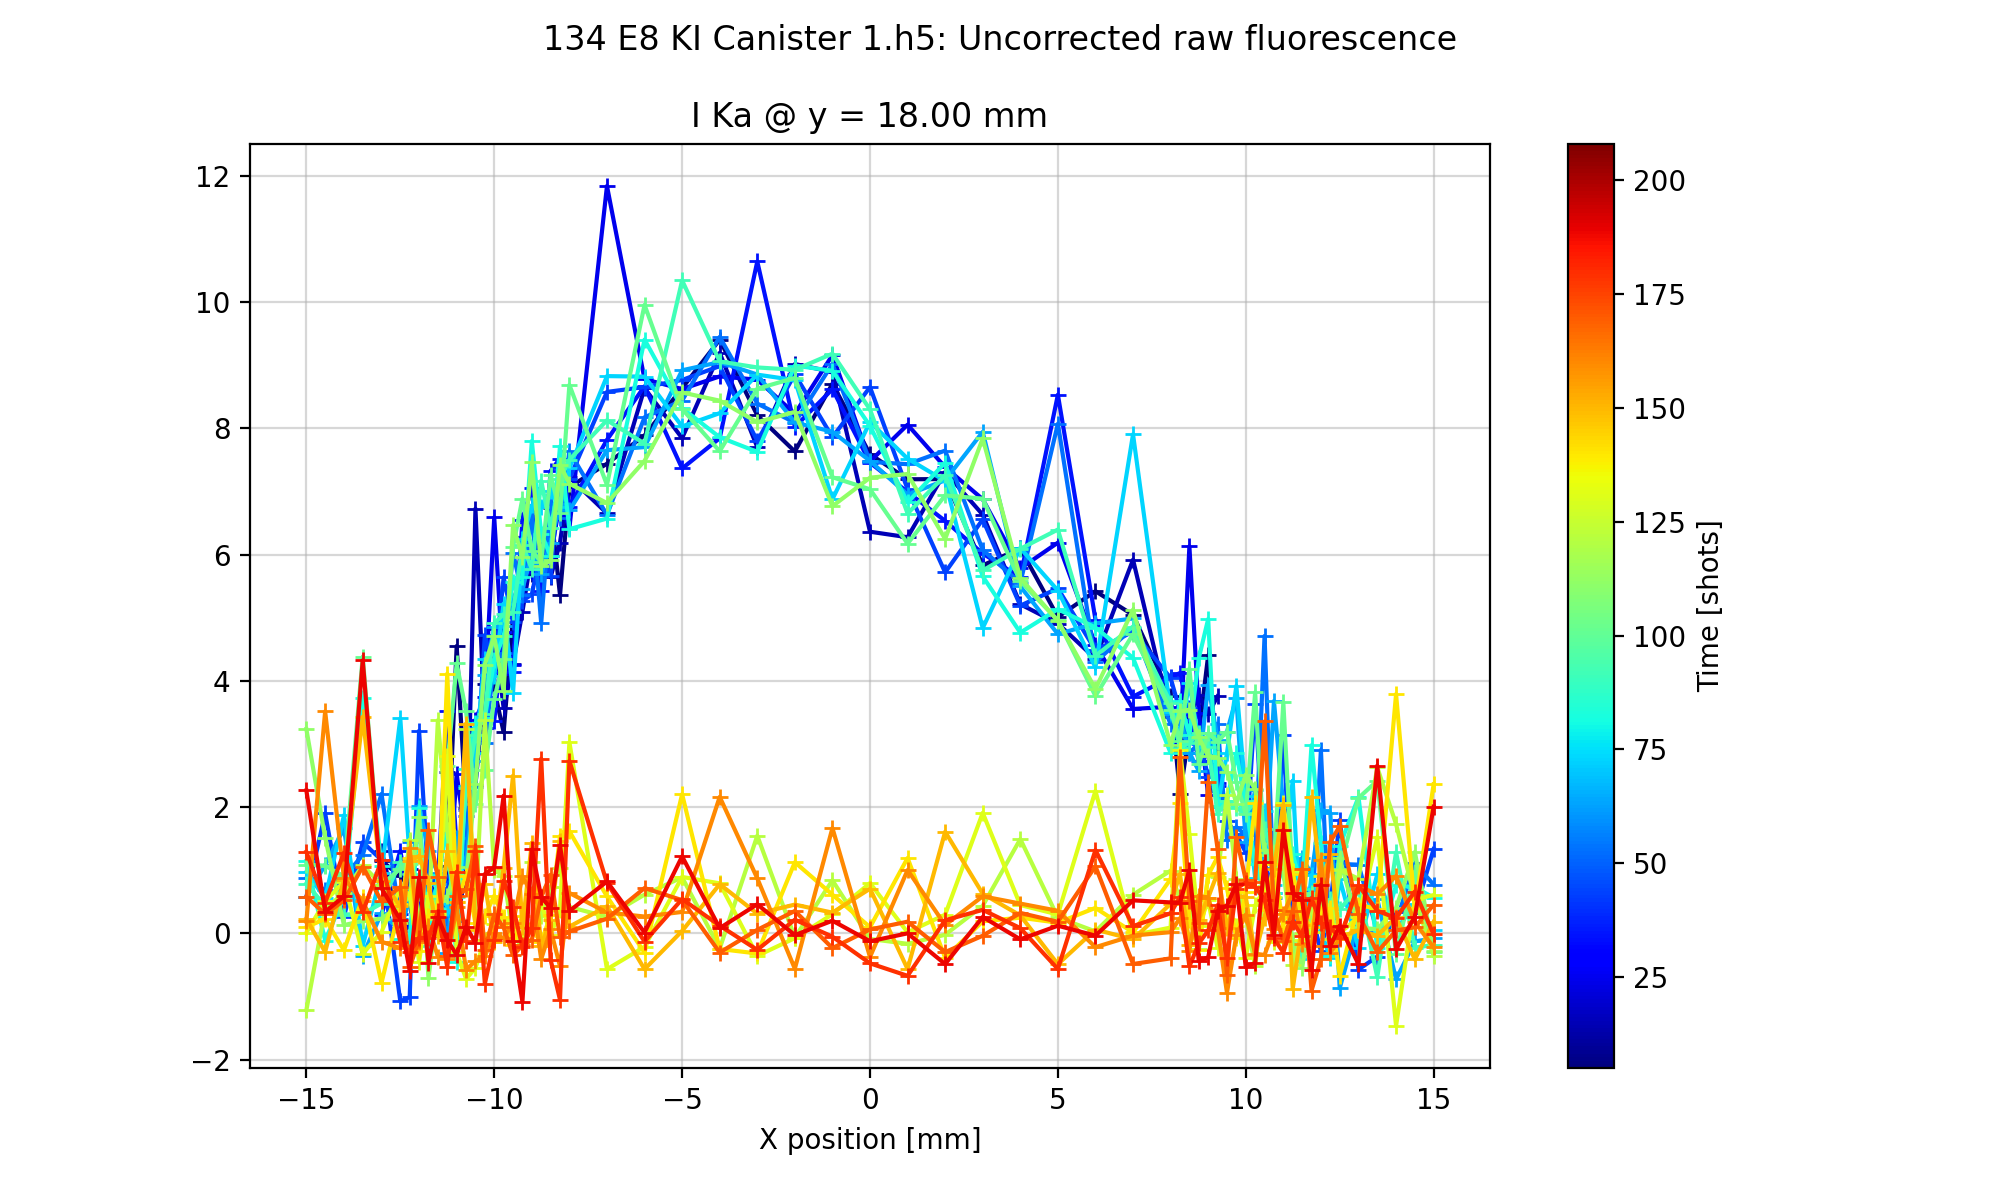

<IPython.core.display.Javascript object>


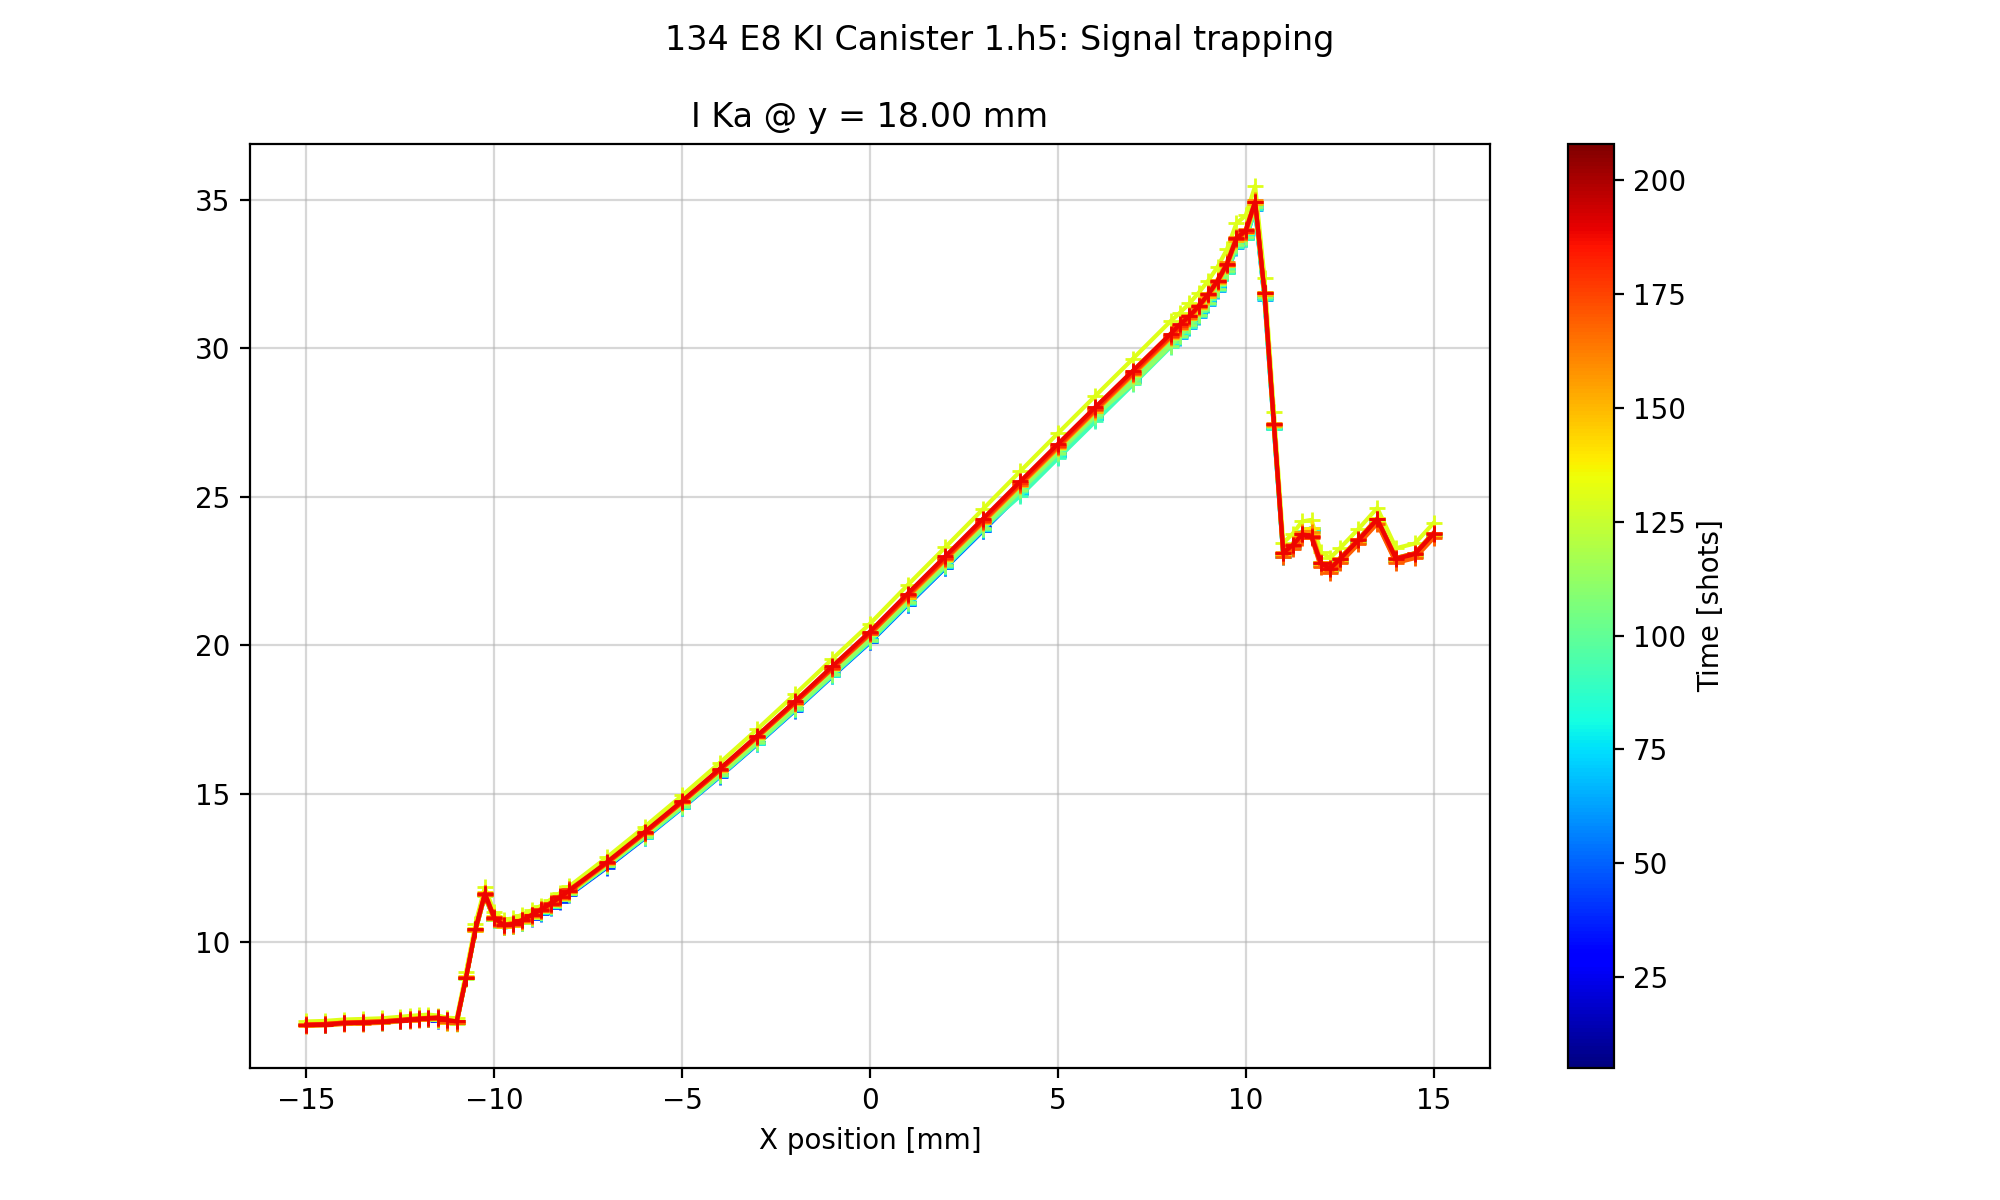

<IPython.core.display.Javascript object>


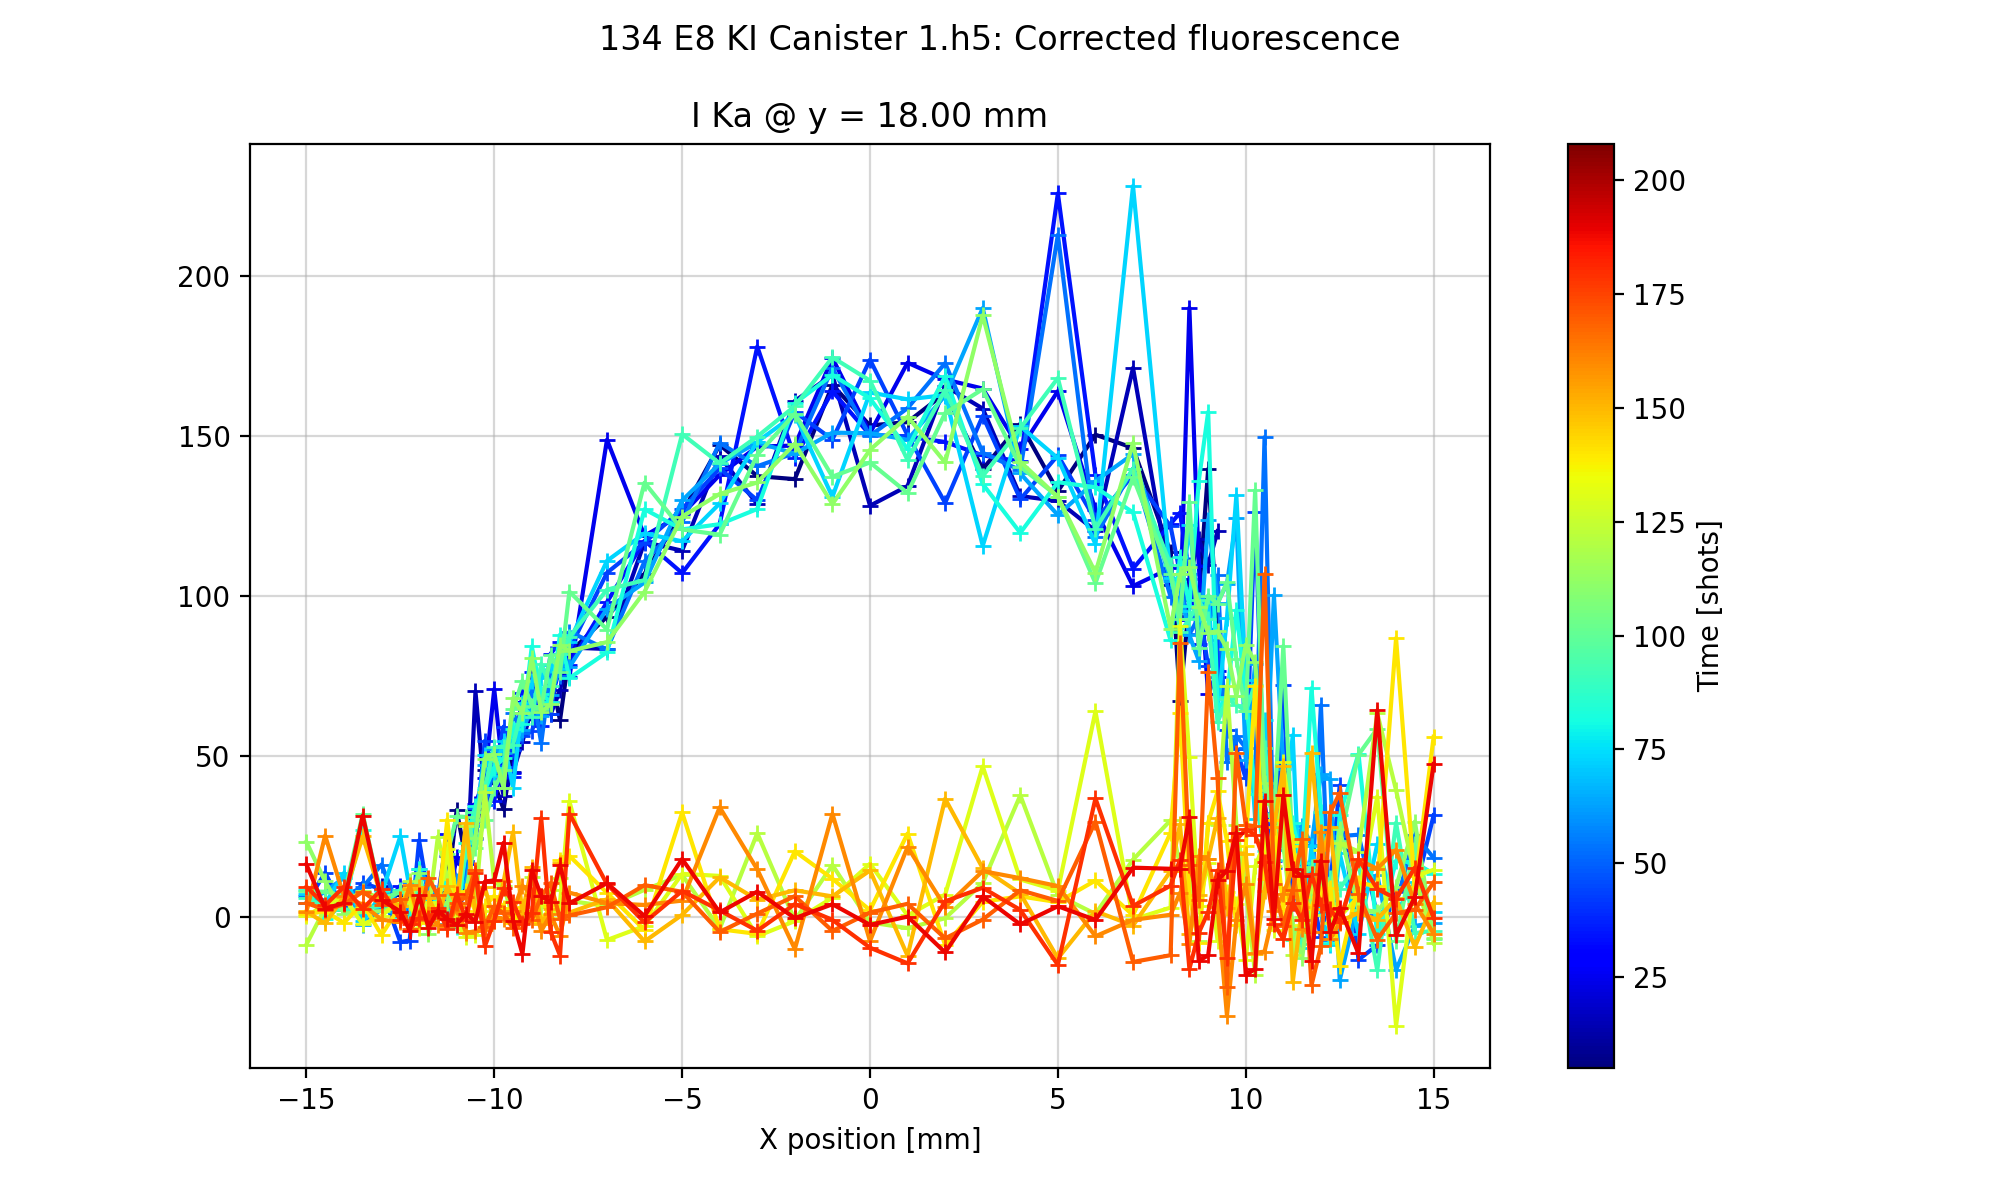

In [6]:
for filename in ["134 E8 KI Canister 1.h5"]:
    
    with h5py.File(filename,'r') as H:
        
        # Read data.
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
        
        x,y,t,zP = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,t,I0 = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/diamondMonitor'] )

        # Calculations
        pinDiode = -np.log(zP/I0)        
        signalTrappingCorrection = applySignalTrapping(x,y,zF,zP,I0)
        zF_corr = zF / signalTrappingCorrection
        
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF_corr[...,i,j]) 
                dz = np.hstack((0, dz))
                zF_corr[np.abs(dz)>35000,i,j] = np.nan # mask large sudden changes in level
    
    # For a particularly useful position, show some line-plots
    i=3
    ym = np.nanmean(y[:,i,:])
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Uncorrected raw fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    for j in range(x.shape[2]-1): # loop time
        plt.plot(x[:,i,j],zF[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Signal trapping" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    
    for j in range(x.shape[2]-1): # loop time
        plt.plot(x[:,i,j],1./signalTrappingCorrection[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
        #plt.plot(x[:,i,j],pinDiode[:,i,j],marker='s',lw=0,c=plt.cm.jet(j/float(t.shape[2])))
        
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Corrected fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    
    for j in range(x.shape[2]-1): # loop time
        plt.plot(x[:,i,j],zF_corr[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
        
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')
    

### Apply signal trapping correction to a different profile

<IPython.core.display.Javascript object>


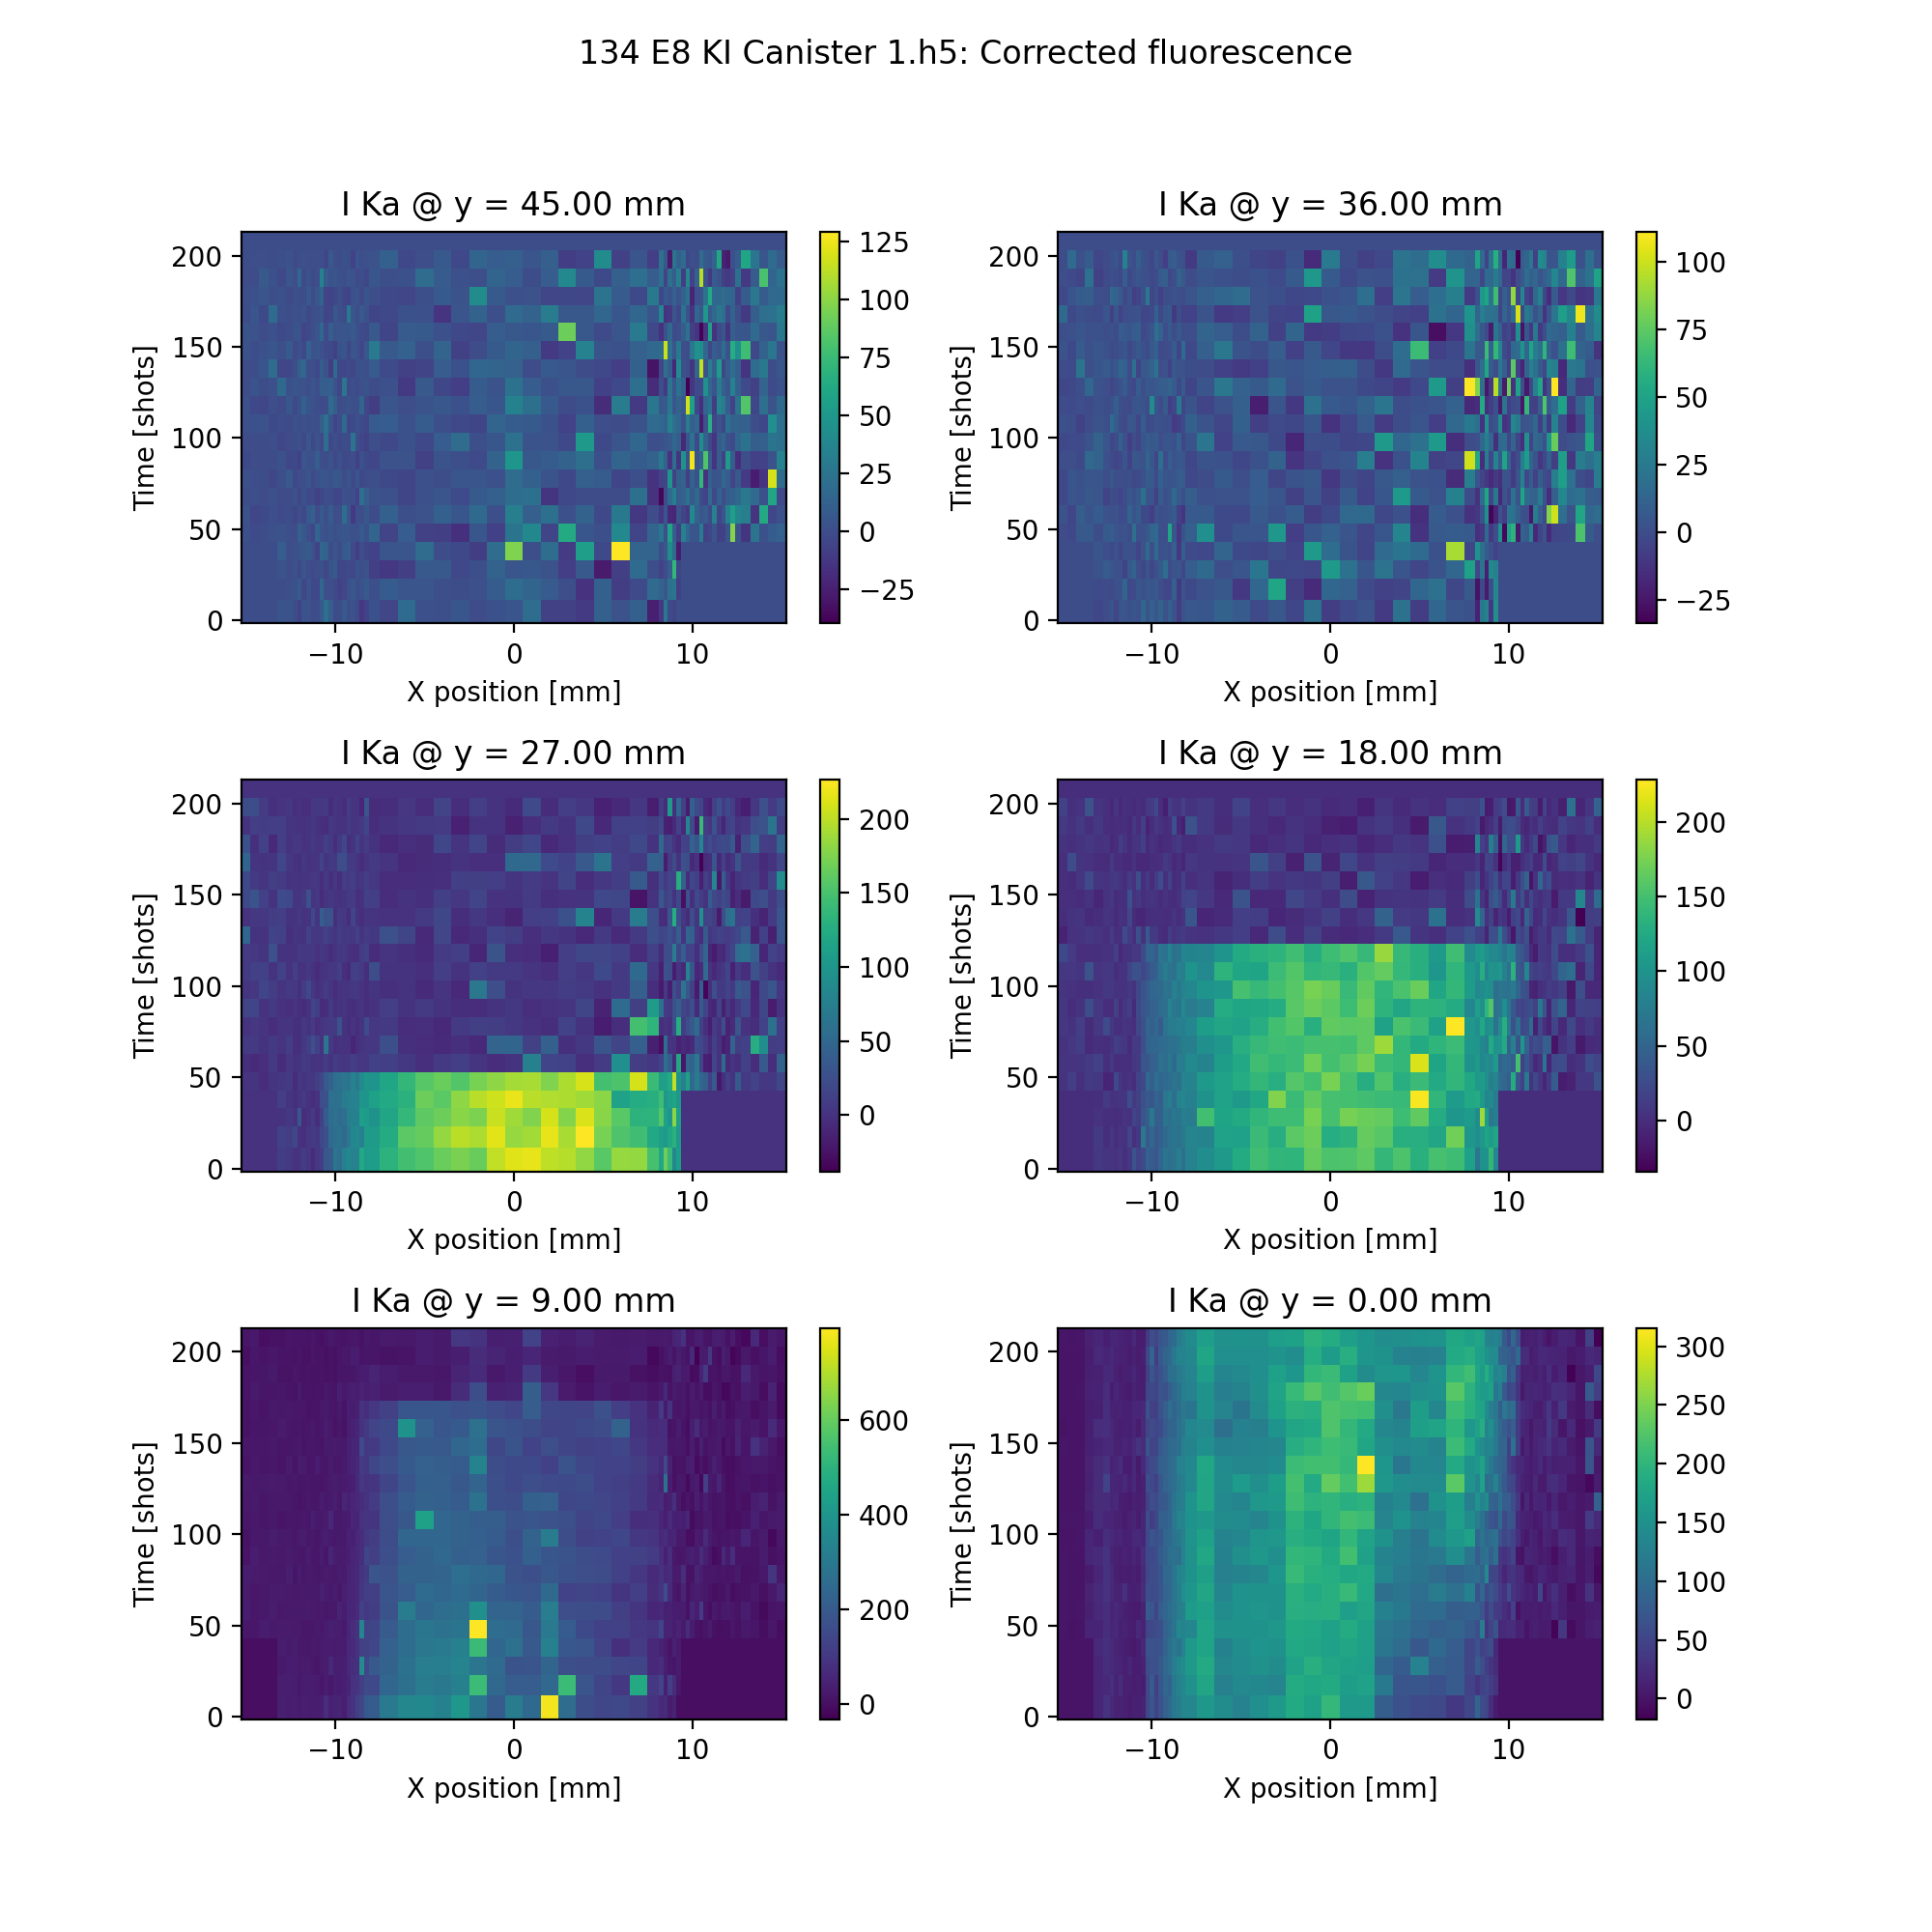

In [14]:
# Plot surfaces of x,t for each y
fig=plt.figure(figsize=(10,10))
plt.suptitle("%s: Corrected fluorescence" % filename)
for i in range(x.shape[1]):
    ym = np.nanmean(y[:,i,:])
    ax=fig.add_subplot(3,int(x.shape[1]/3),i+1)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.xlabel('X position [mm]'); plt.ylabel('Time [shots]')
    ph=ax.pcolormesh(x[:,i,:],t[:,i,:],np.nan_to_num(zF_corr[:,i,:]))
    plt.colorbar(ph)
plt.subplots_adjust(hspace=.4);

<IPython.core.display.Javascript object>


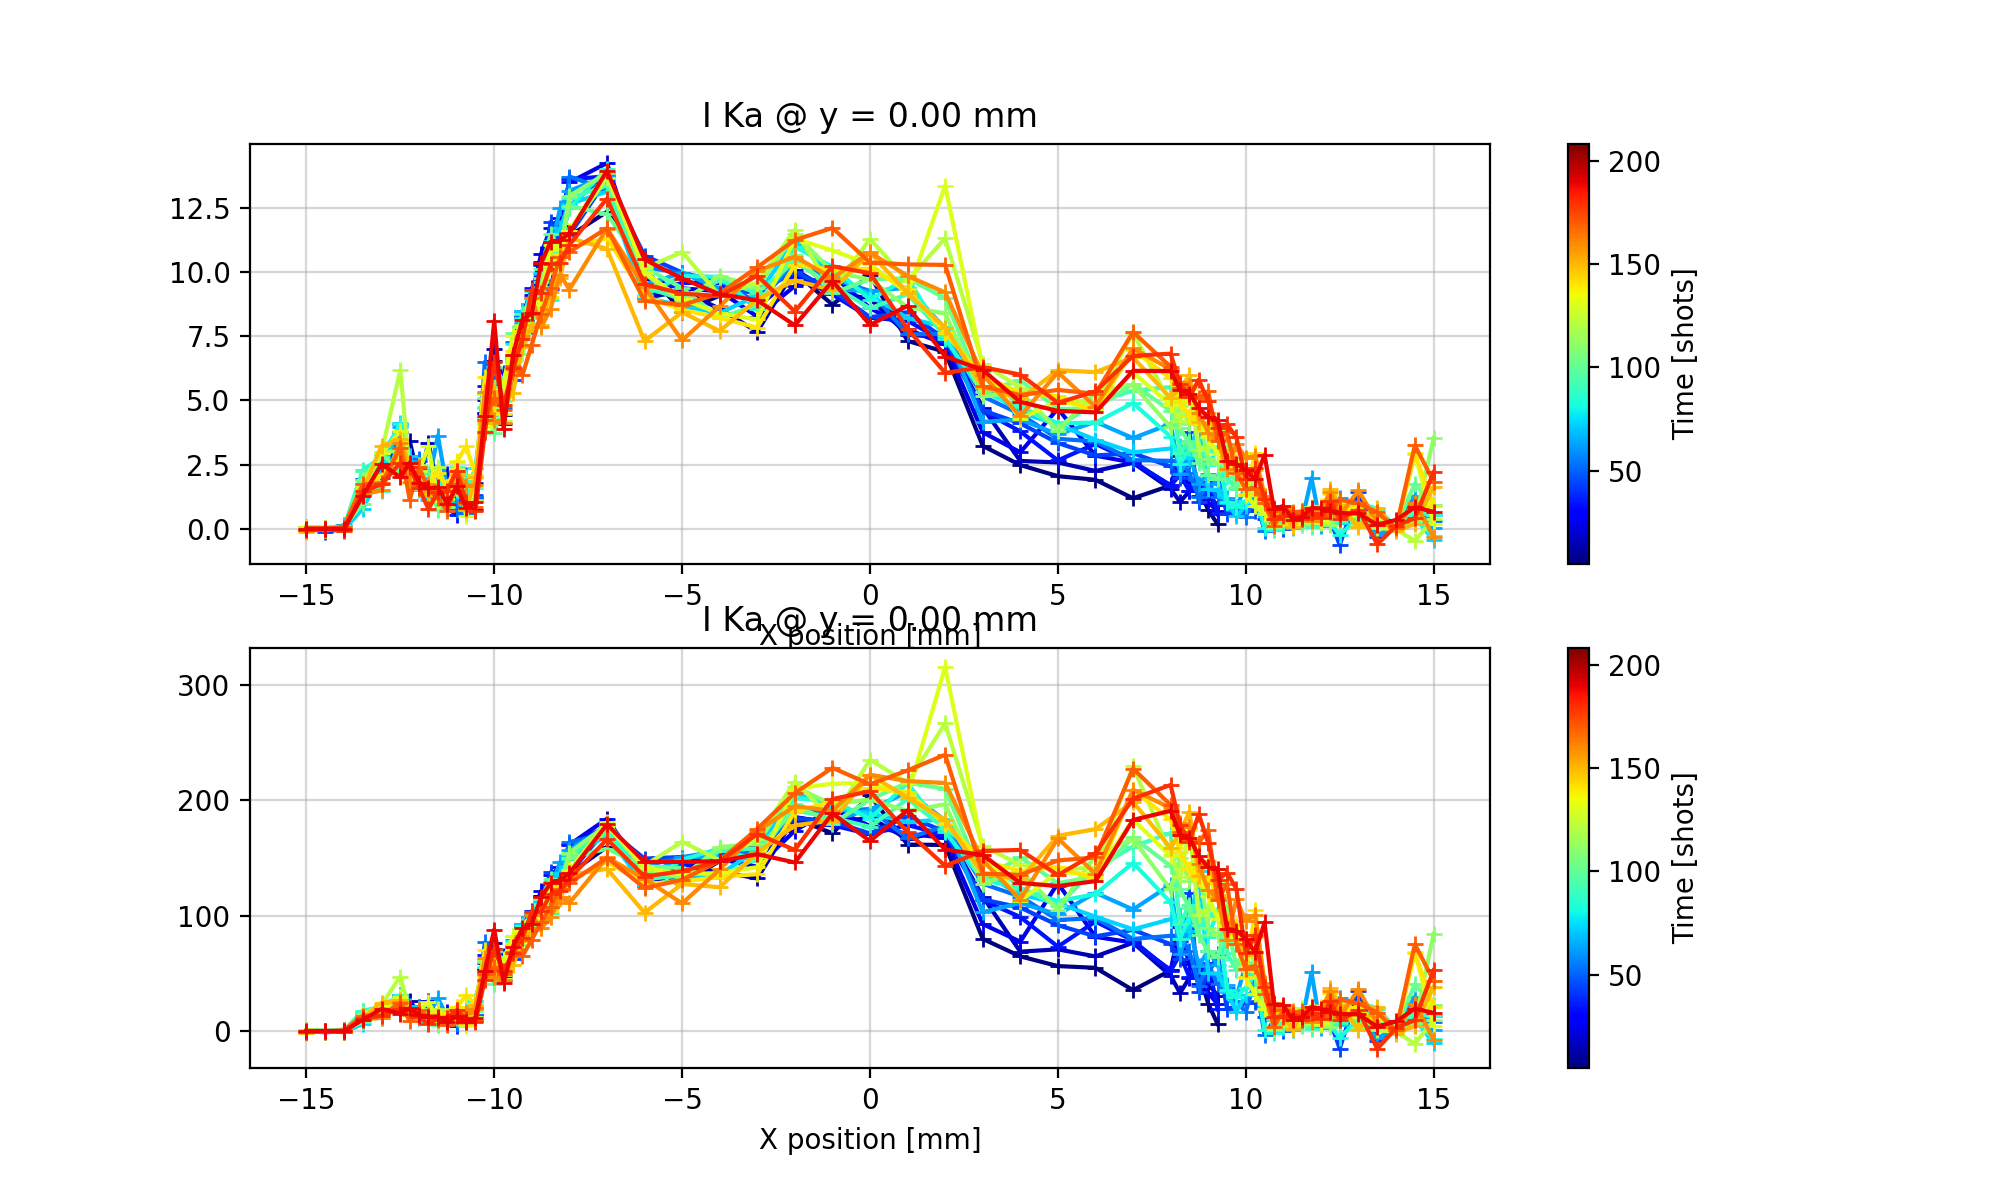

In [18]:
# For a particularly useful position, show some line-plots
i=5
ym = np.nanmean(y[:,i,:])

fig=plt.figure(figsize=(10,6))

ax=fig.add_subplot(211)
plt.title("%s: Uncorrected raw fluorescence" % filename)
plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
ax.grid(alpha=.5)
for j in range(x.shape[2]-1): # loop time
    ax.plot(x[:,i,j],zF[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
plt.xlabel('X position [mm]')
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
plt.colorbar(sm,ax=plt.gca(),label='Time [shots]')

ax=fig.add_subplot(212)
plt.title("%s: Corrected fluorescence" % filename)
plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
plt.grid(alpha=.5)
for j in range(x.shape[2]-1): # loop time
    ax.plot(x[:,i,j],zF_corr[:,i,j],marker='+',c=plt.cm.jet(j/float(t.shape[2])))
plt.xlabel('X position [mm]')
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:].max()))
plt.colorbar(sm,ax=plt.gca(),label='Time [shots]');

## 3. Use full canister data to calibrate the KI fluorescence level with HFA-134a.

In [81]:
filenames = glob.glob("134 E8 KI Canister *.h5")
print(filenames)

# Get a good clean profile in the middle of the can . Specify vertical scan pos. with 'i'
vPositions=(3,3,3)

# How many shots to take for maximum?
maxShotsList = (100,200,100)

mgPermL = 2.0

['134 E8 KI Canister 1.h5', '134 E8 KI Canister 2.h5', '134 E8 KI Canister 13.h5']


<IPython.core.display.Javascript object>


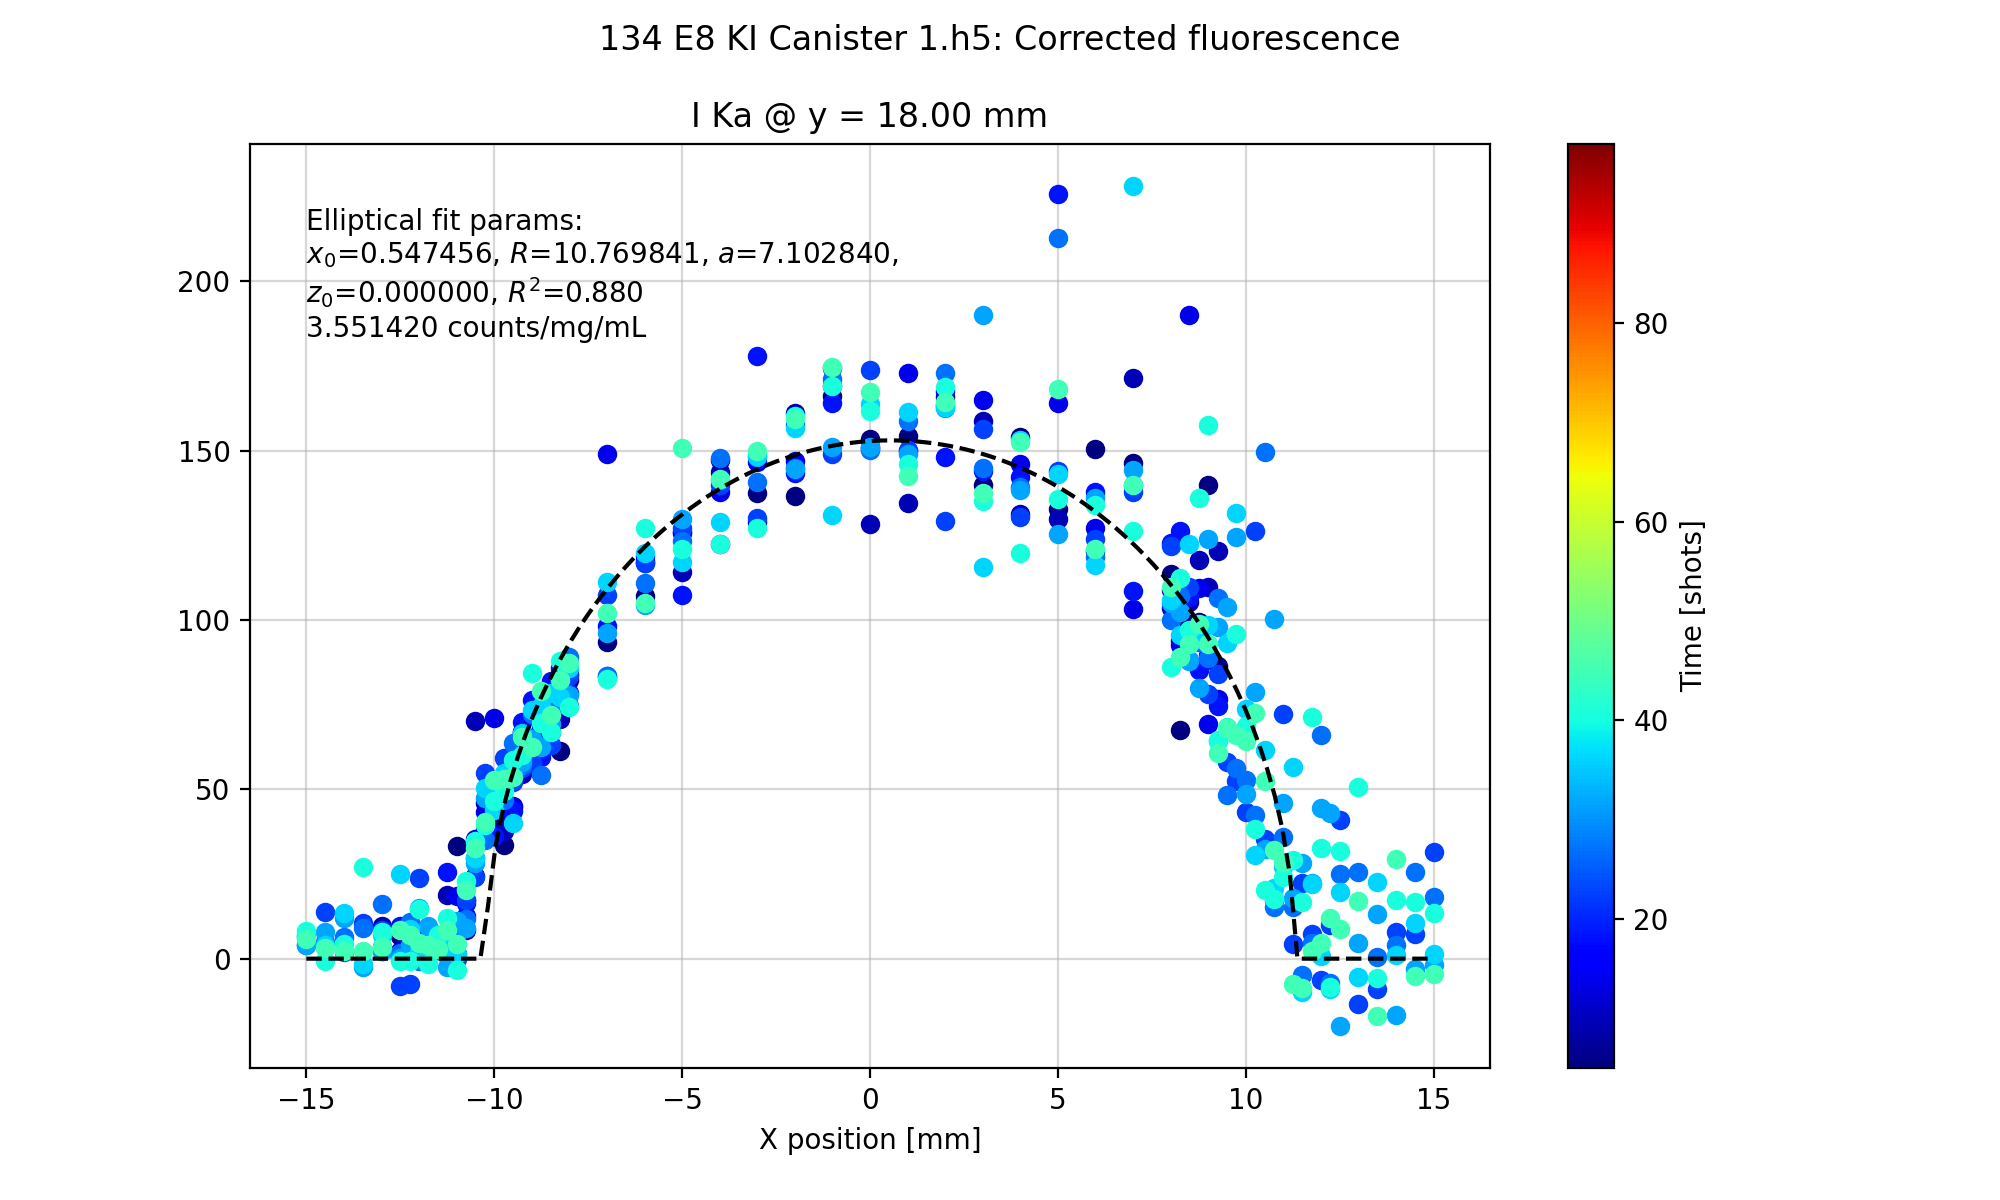

<IPython.core.display.Javascript object>


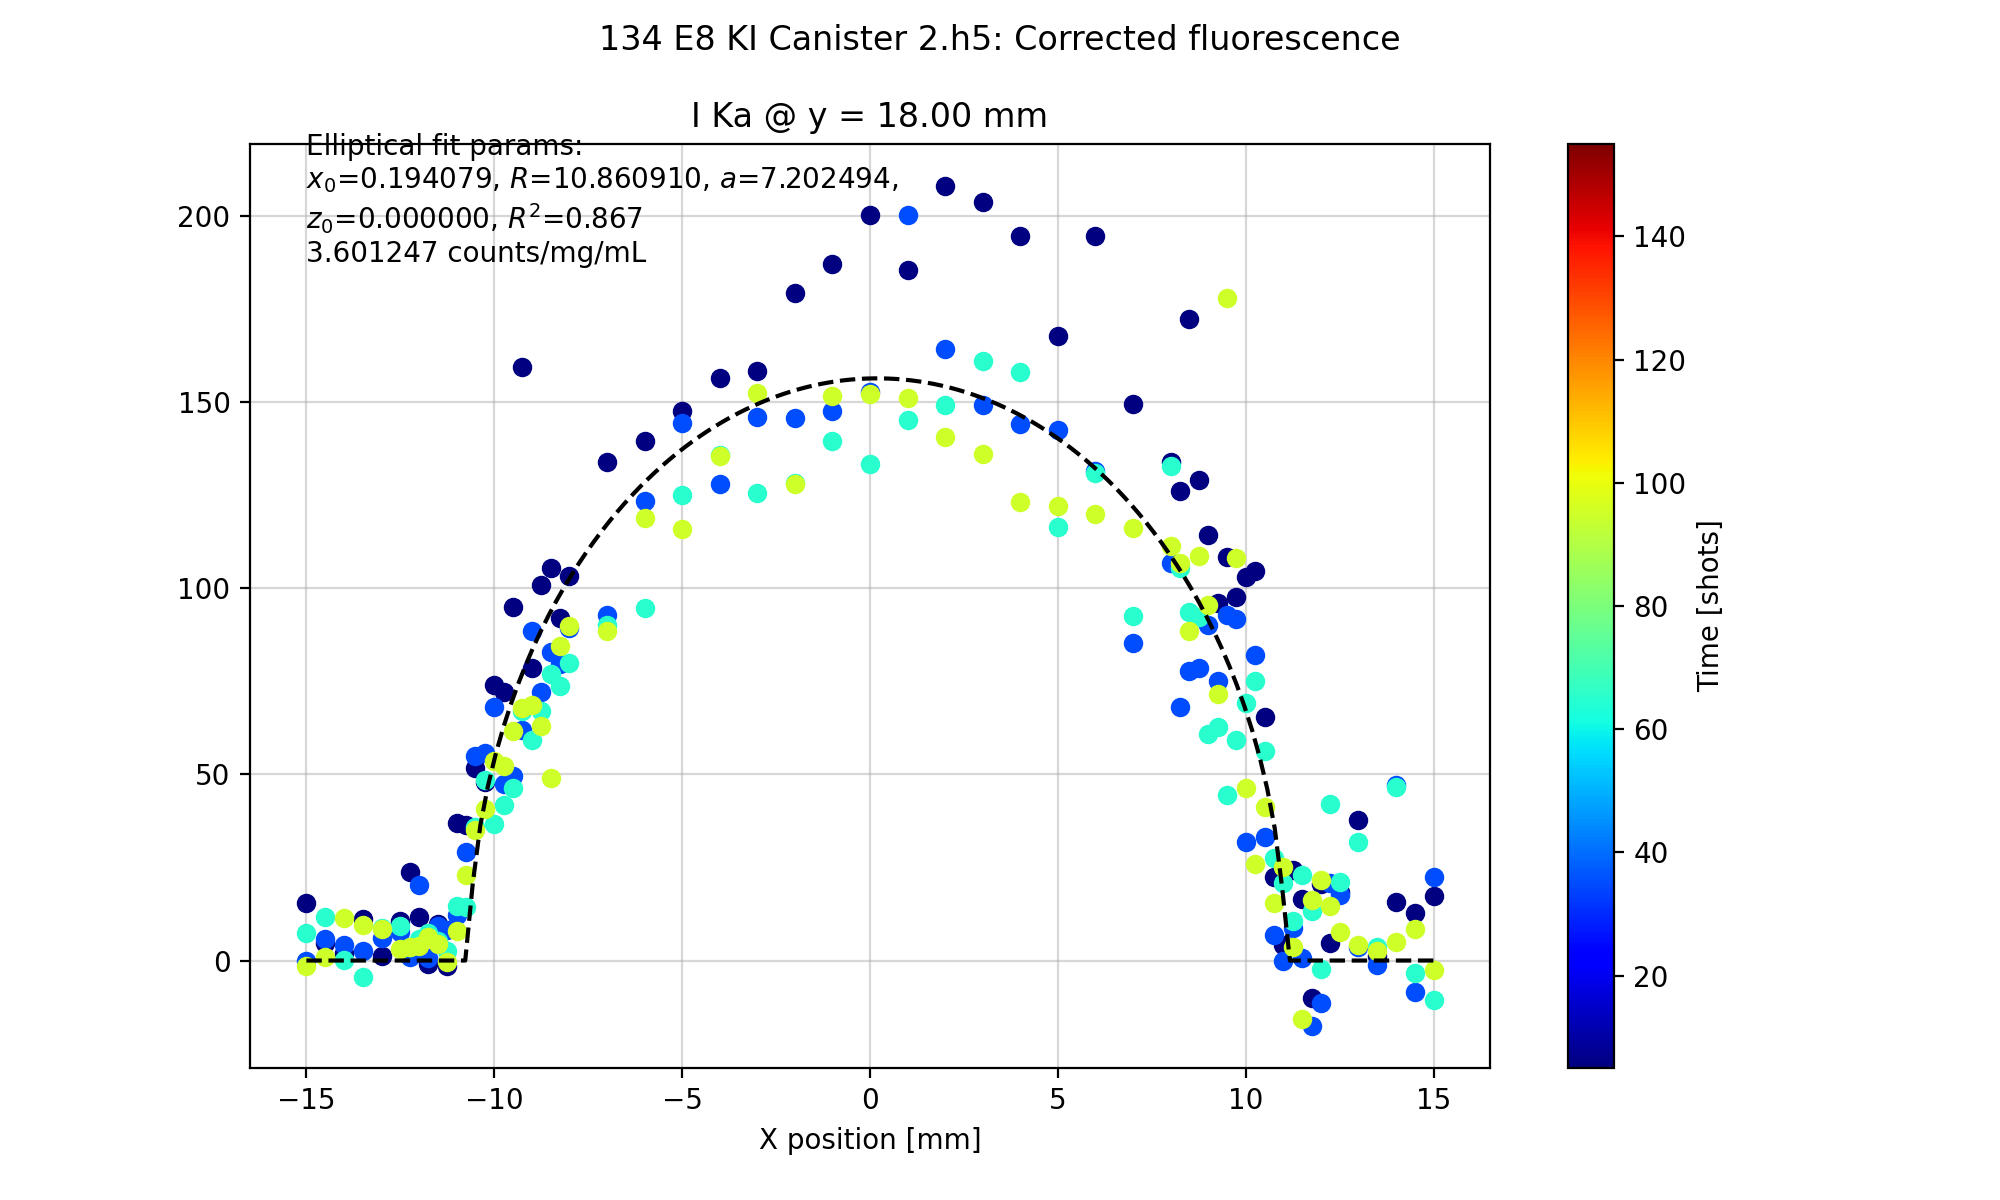

<IPython.core.display.Javascript object>


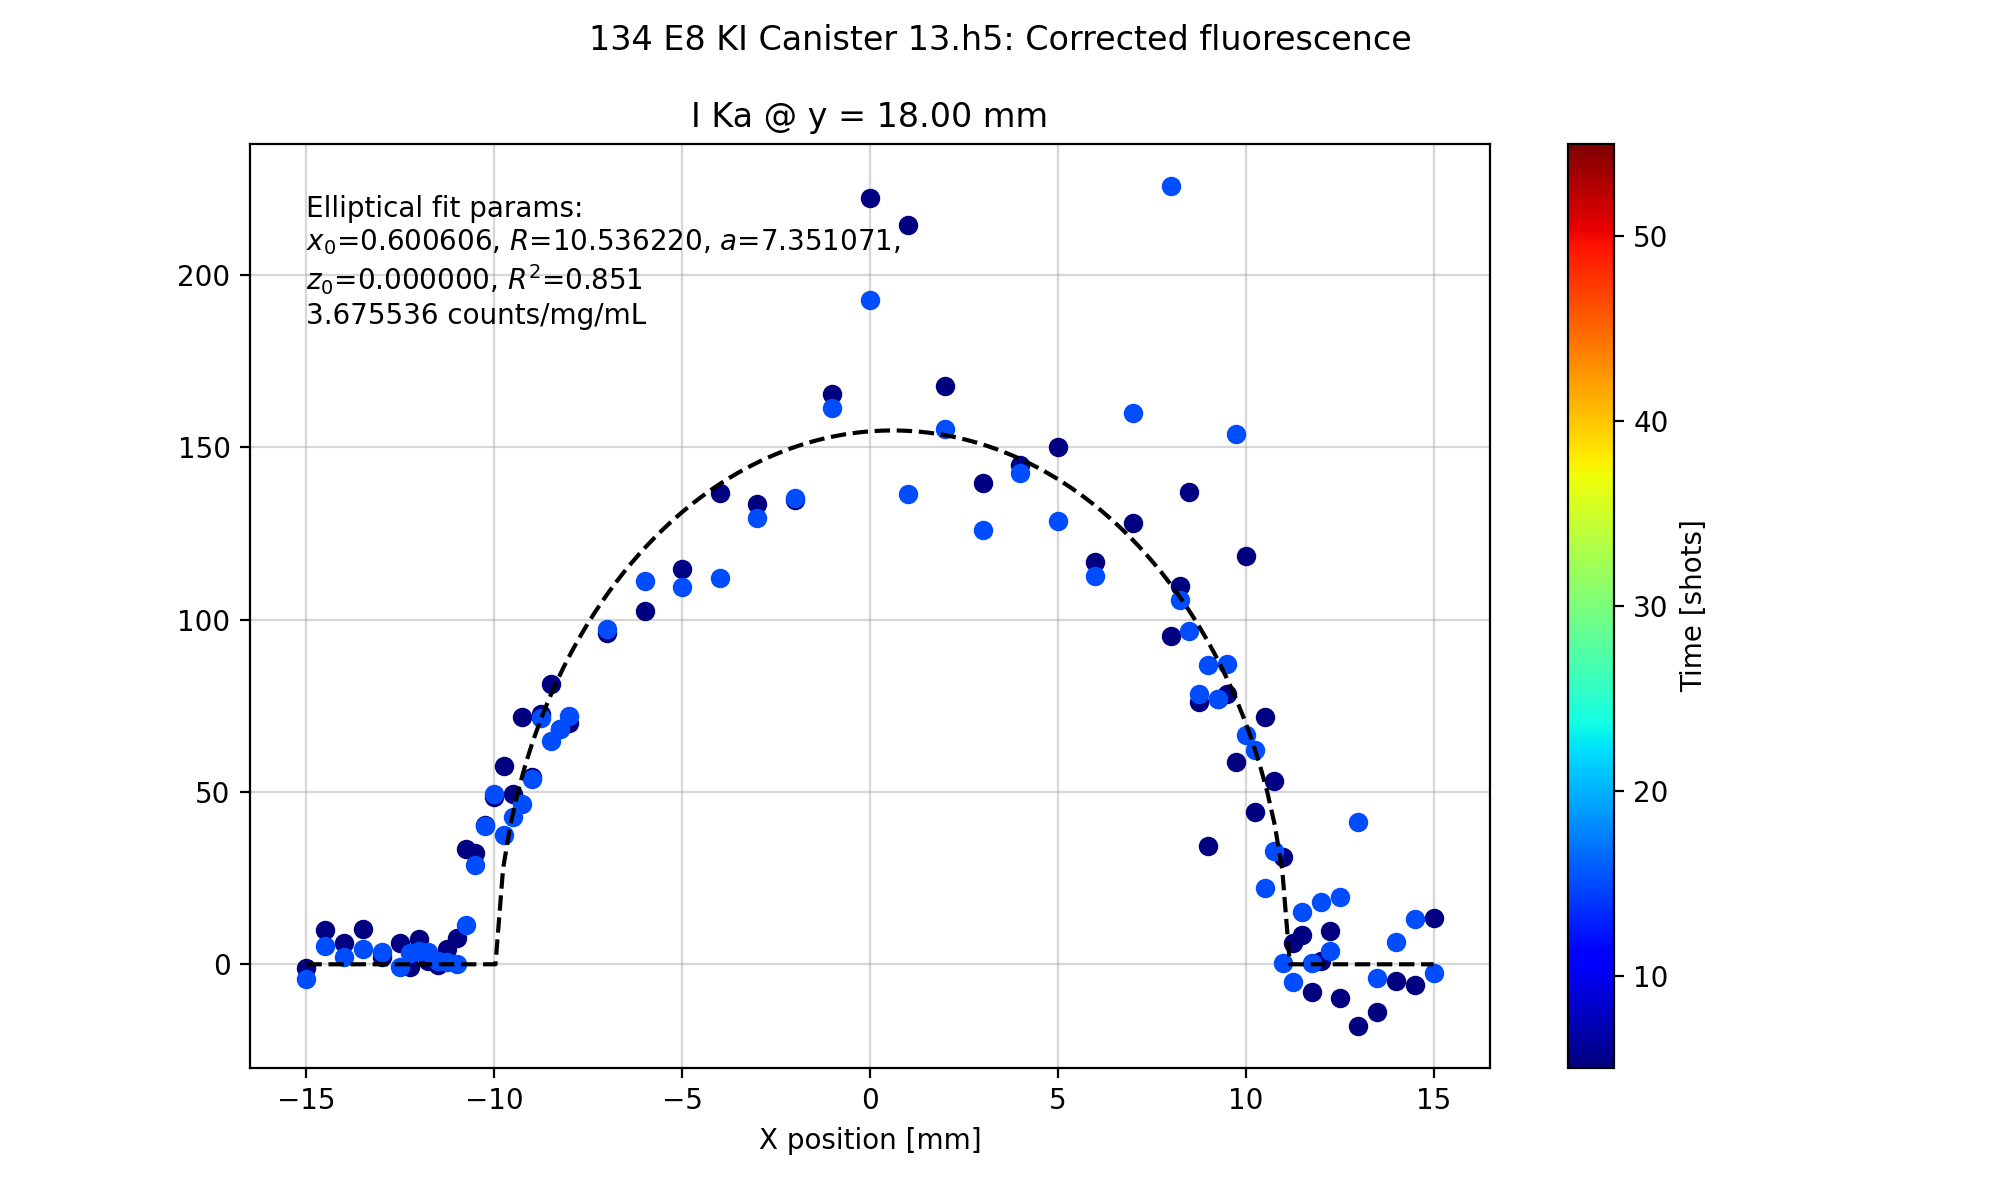

In [83]:
for filename,vPos,maxShots in zip(filenames,vPositions,maxShotsList):
    
    with h5py.File(filename,'r') as H:
        
        # Read data.
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
        
        x,y,t,zP = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,t,I0 = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/diamondMonitor'] )

        
        # Calculations
        pinDiode = -np.log(zP/I0)        
        signalTrappingCorrection = applySignalTrapping(x,y,zF,zP,I0)
        zF_corr = zF / signalTrappingCorrection
        
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF_corr[...,i,j]) 
                dz = np.hstack((0, dz))
                zF_corr[np.abs(dz)>35000,i,j] = np.nan # mask large sudden changes in level
    
    # y position for chosen profile
    i=vPos
    ym = np.nanmean(y[:,i,:])
    
    # Limit the time range so that the profile's not empty
    shotCounter = np.median(t[:,i,:],axis=0)
    timax = np.where(shotCounter>maxShots)[0][0] # stop after some number of shots
    
    # Fit elliptical profile to the data within the time range.
    fellipse = lambda x,x0,r,a,z0: a*secant(x-x0,r)
    xFit = x[:,i,:timax]; zFit = zF_corr[:,i,:timax]
    flt = ~np.isnan(xFit) & ~np.isnan(zFit) # Use non NaN points
    #flt = flt & (xFit<10)
    popt,pcov = scipy.optimize.curve_fit(fellipse,xFit[flt],zFit[flt],p0=(-3,1,1,0))
    r2 = calcR2(fellipse,xFit[flt],zFit[flt],popt)
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Corrected fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    
    for j in np.arange(0,timax): # loop time for the first portion of the experiment
        plt.plot(x[:,i,j],zF_corr[:,i,j],marker='o',lw=0,c=plt.cm.jet(j/float(t.shape[2])))
        
    x_ = np.linspace(x[:,i,:timax].min(),x[:,i,:timax].max(),150)
    plt.plot(x_,fellipse(x_,*popt),ls='--',c='k')
    plt.text(-15,fellipse(x_,*popt).max()*1.2,\
     "Elliptical fit params:\n$x_0$=%f, $R$=%f, $a$=%f,\n$z_0$=%f, $R^2$=%.3f\n%f counts/mg/mL" % (popt[0],popt[1],popt[2],popt[3],r2,popt[2]/mgPermL))
        
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:timax].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]');

## 4. Repeat calibration with other propellants

### HFA-152a

In [105]:
filenames = glob.glob("152 E8 KI Canister *.h5")
print(filenames)
propellant='152'

# Get a good clean profile in the middle of the can . Specify vertical scan pos. with 'i'
vPositions=(3,3,3)

# How many shots to take for maximum?
maxShotsList = (200,150,150)

mgPermL = 2.0

['152 E8 KI Canister 9.h5', '152 E8 KI Canister 3.h5', '152 E8 KI Canister 10.h5']


<IPython.core.display.Javascript object>


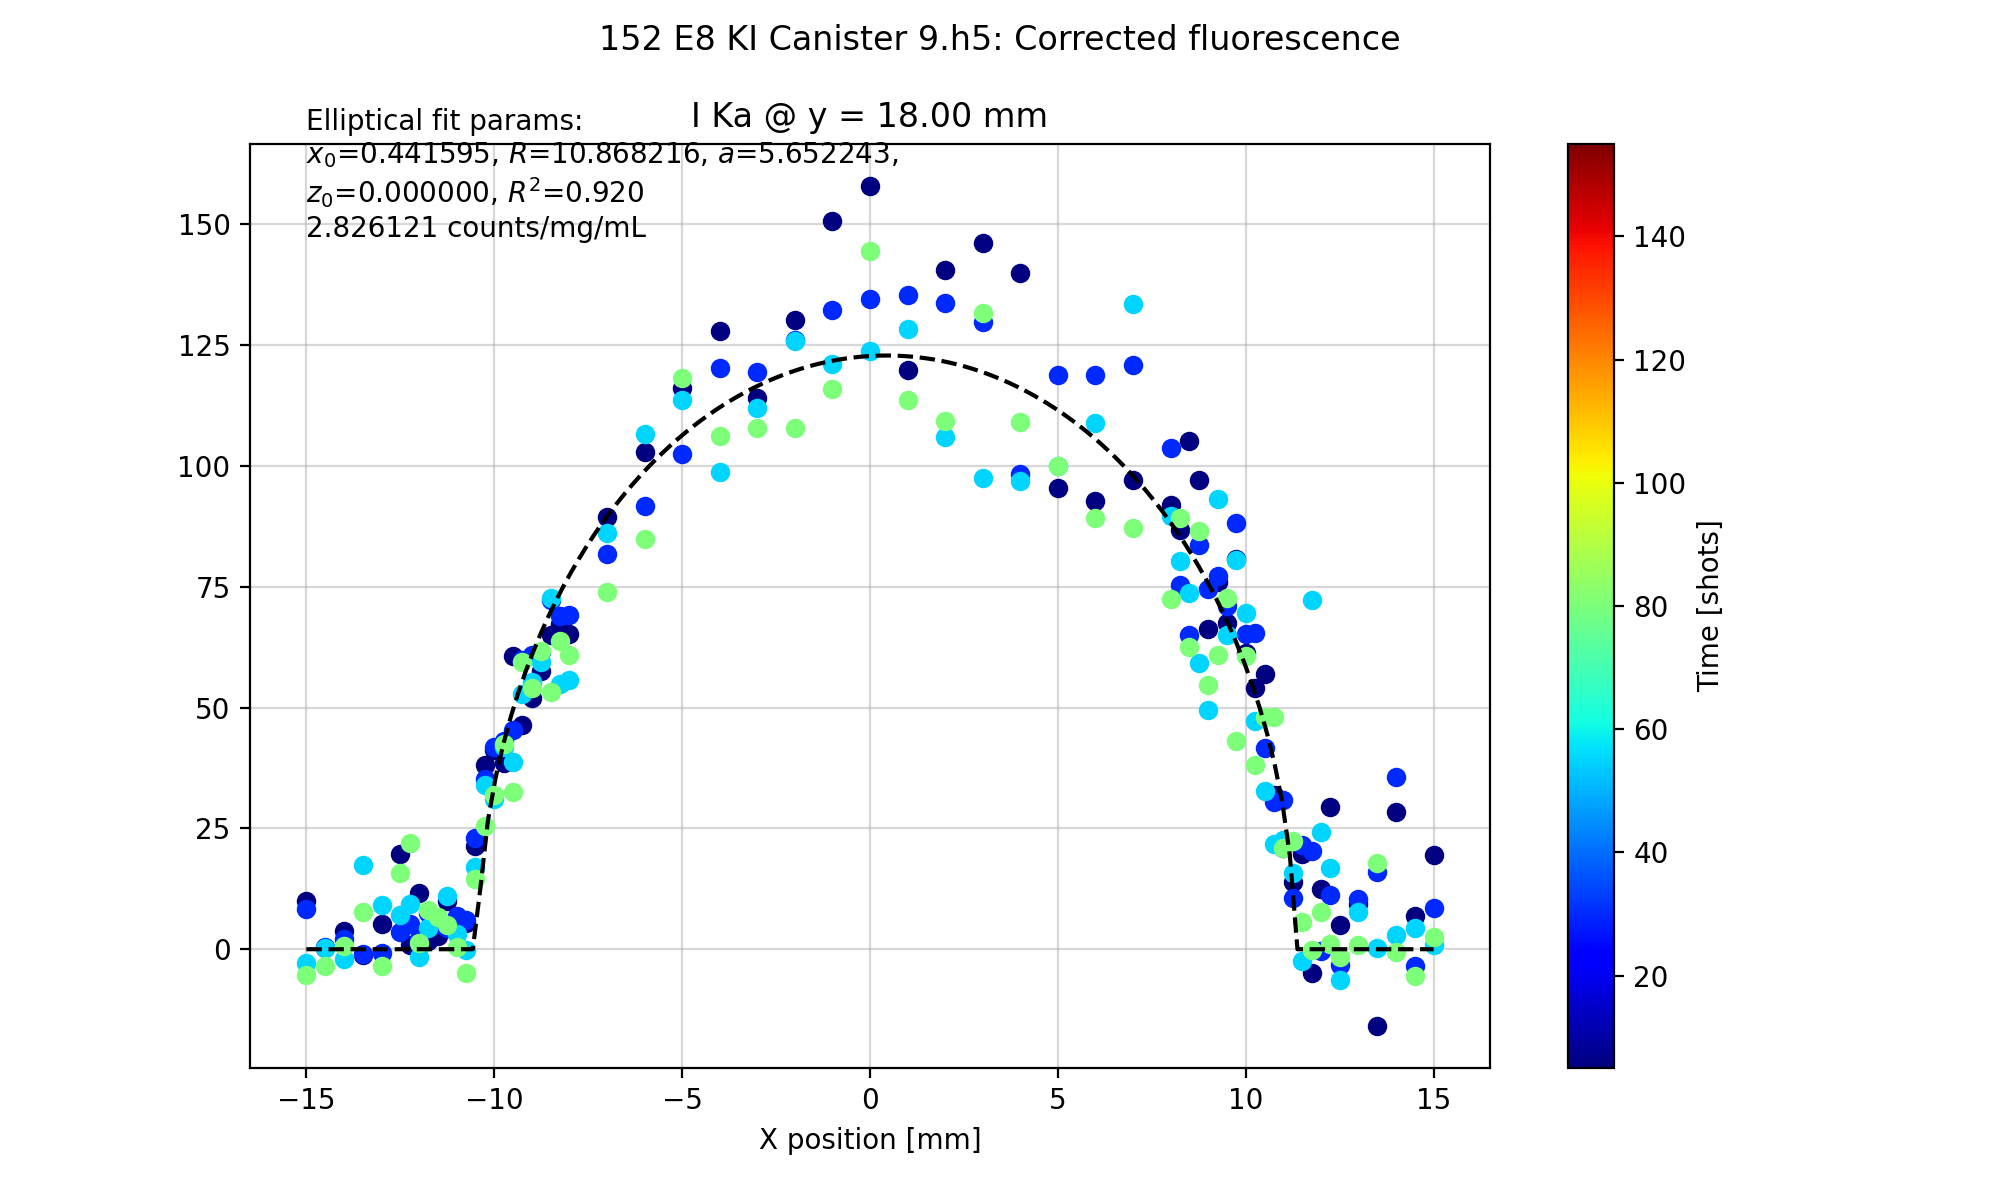

<IPython.core.display.Javascript object>


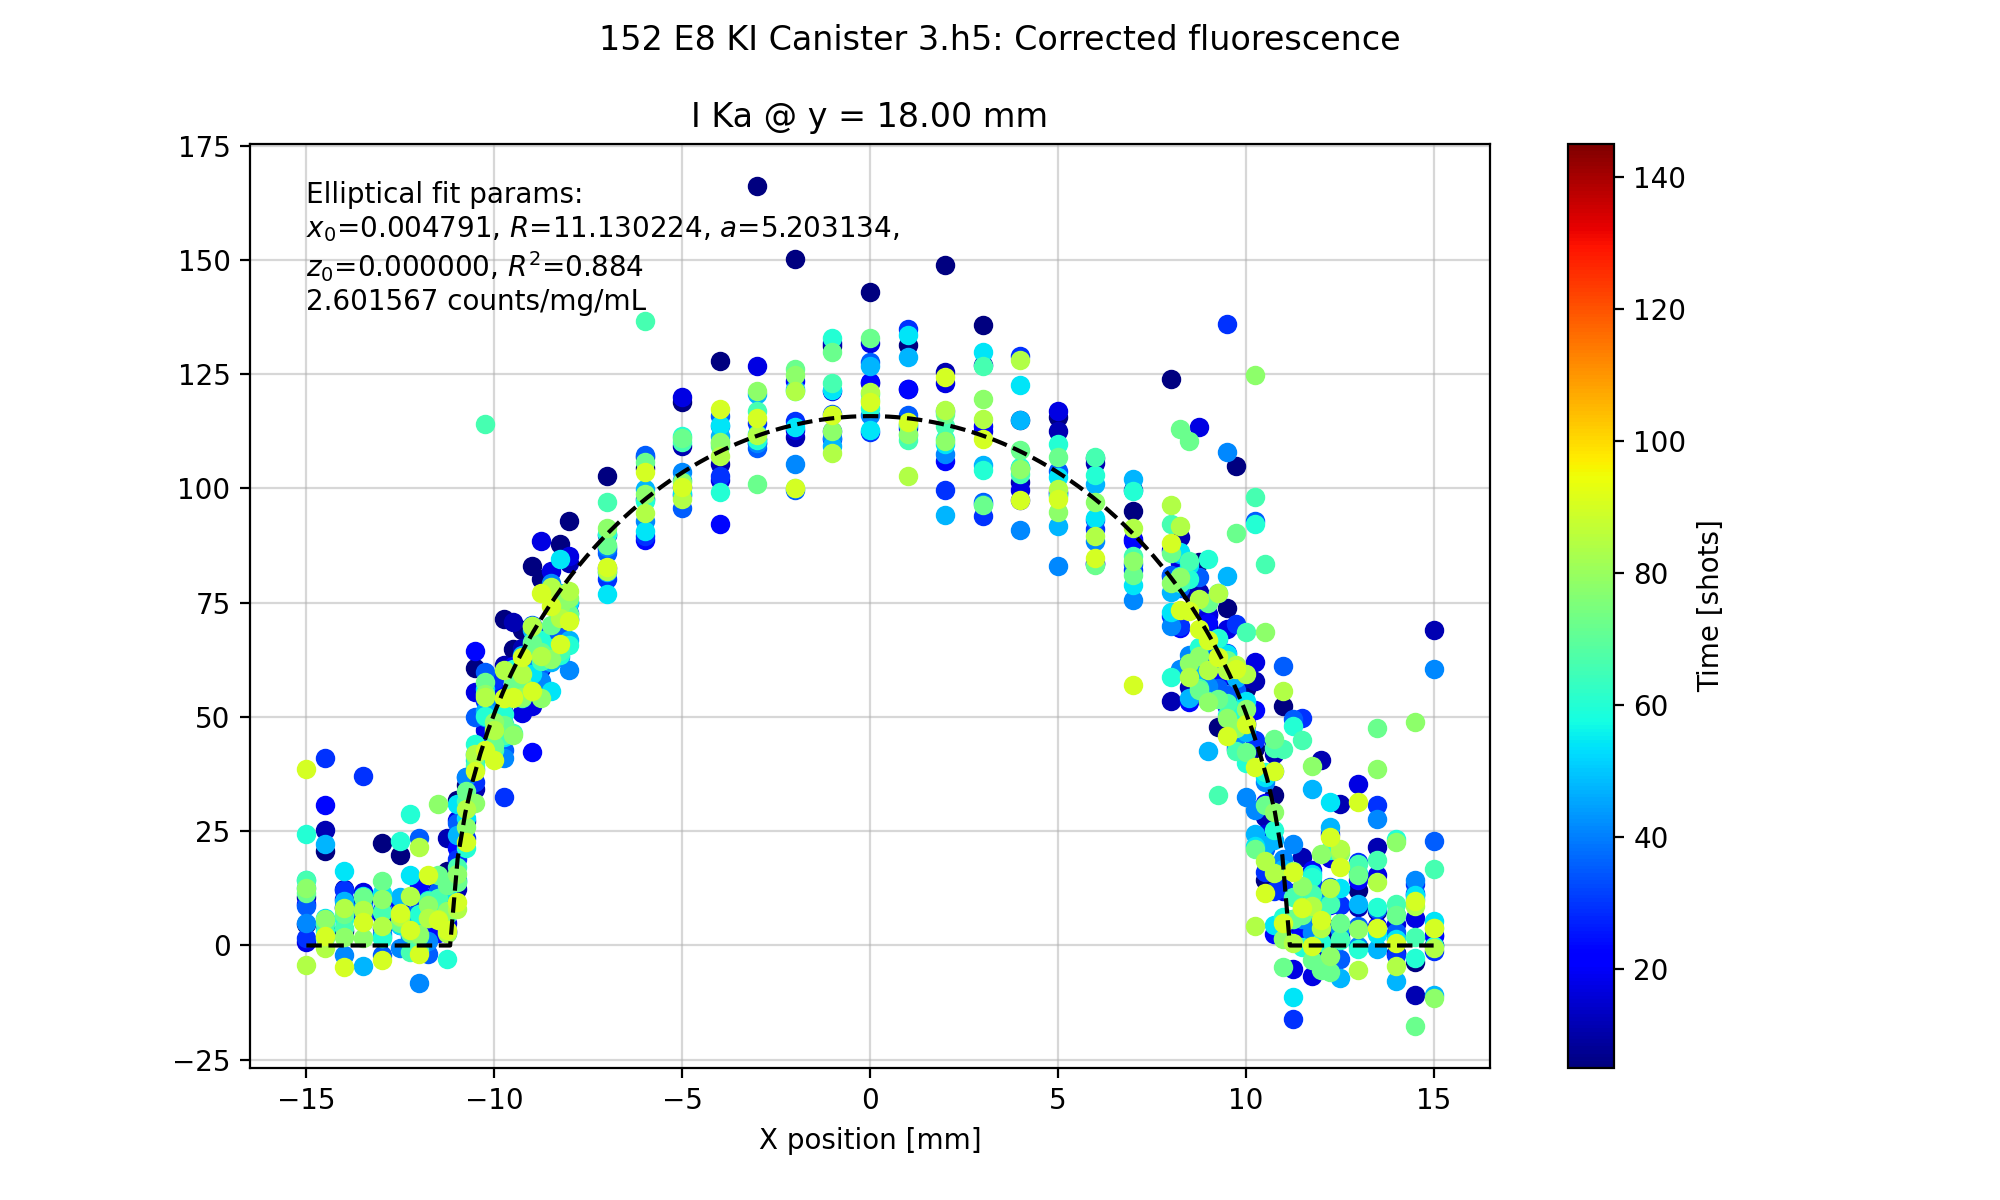

<IPython.core.display.Javascript object>


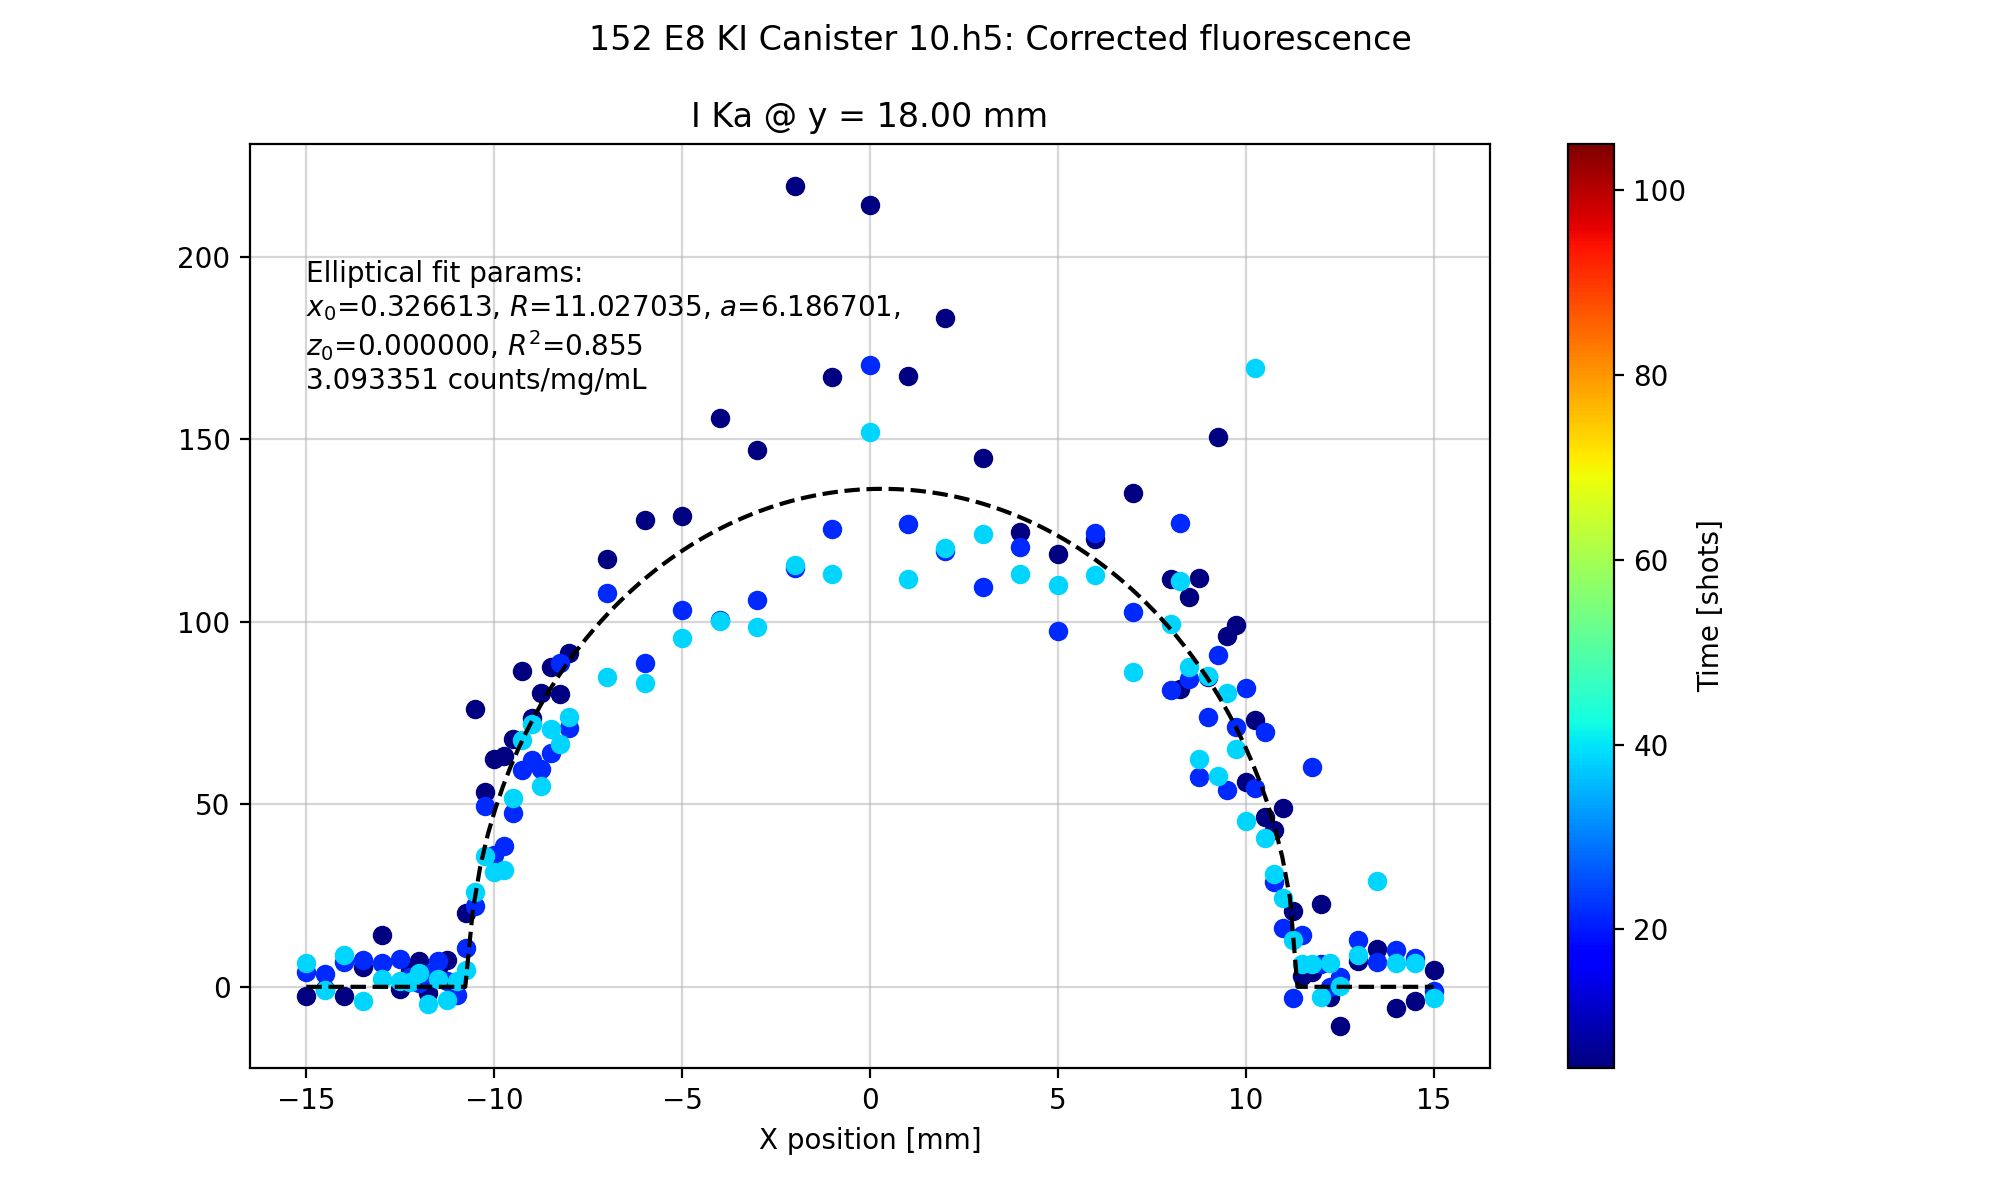

In [106]:
for filename,vPos,maxShots in zip(filenames,vPositions,maxShotsList):
    
    with h5py.File(filename,'r') as H:
        
        # Read data.
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
        
        x,y,t,zP = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,t,I0 = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/diamondMonitor'] )

        
        # Calculations
        pinDiode = -np.log(zP/I0)        
        signalTrappingCorrection = applySignalTrapping(x,y,zF,zP,I0,propellant=propellant)
        zF_corr = zF / signalTrappingCorrection
        
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF_corr[...,i,j]) 
                dz = np.hstack((0, dz))
                zF_corr[np.abs(dz)>35000,i,j] = np.nan # mask large sudden changes in level
    
    # y position for chosen profile
    i=vPos
    ym = np.nanmean(y[:,i,:])
    
    # Limit the time range so that the profile's not empty
    shotCounter = np.median(t[:,i,:],axis=0)
    timax = np.where(shotCounter>maxShots)[0][0] # stop after some number of shots
    
    # Fit elliptical profile to the data within the time range.
    fellipse = lambda x,x0,r,a,z0: a*secant(x-x0,r)
    xFit = x[:,i,:timax]; zFit = zF_corr[:,i,:timax]
    flt = ~np.isnan(xFit) & ~np.isnan(zFit) # Use non NaN points
    #flt = flt & (xFit<10)
    popt,pcov = scipy.optimize.curve_fit(fellipse,xFit[flt],zFit[flt],p0=(-3,1,1,0))
    r2 = calcR2(fellipse,xFit[flt],zFit[flt],popt)
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Corrected fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    
    for j in np.arange(0,timax): # loop time for the first portion of the experiment
        plt.plot(x[:,i,j],zF_corr[:,i,j],marker='o',lw=0,c=plt.cm.jet(j/float(t.shape[2])))
        
    x_ = np.linspace(x[:,i,:timax].min(),x[:,i,:timax].max(),150)
    plt.plot(x_,fellipse(x_,*popt),ls='--',c='k')
    plt.text(-15,fellipse(x_,*popt).max()*1.2,\
     "Elliptical fit params:\n$x_0$=%f, $R$=%f, $a$=%f,\n$z_0$=%f, $R^2$=%.3f\n%f counts/mg/mL" % (popt[0],popt[1],popt[2],popt[3],r2,popt[2]/mgPermL))
        
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:timax].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]');

### Repeat for 1234ze(E)

In [109]:
filenames = glob.glob("1234 E8 KI Canister *.h5")
print(filenames)
propellant='1234E'

# Get a good clean profile in the middle of the can . Specify vertical scan pos. with 'i'
vPositions=(3,3,3)

# How many shots to take for maximum?
maxShotsList = (200,150,150)

mgPermL = 2.0

['1234 E8 KI Canister 11.h5', '1234 E8 KI Canister 4.h5', '1234 E8 KI Canister 3.h5']


<IPython.core.display.Javascript object>


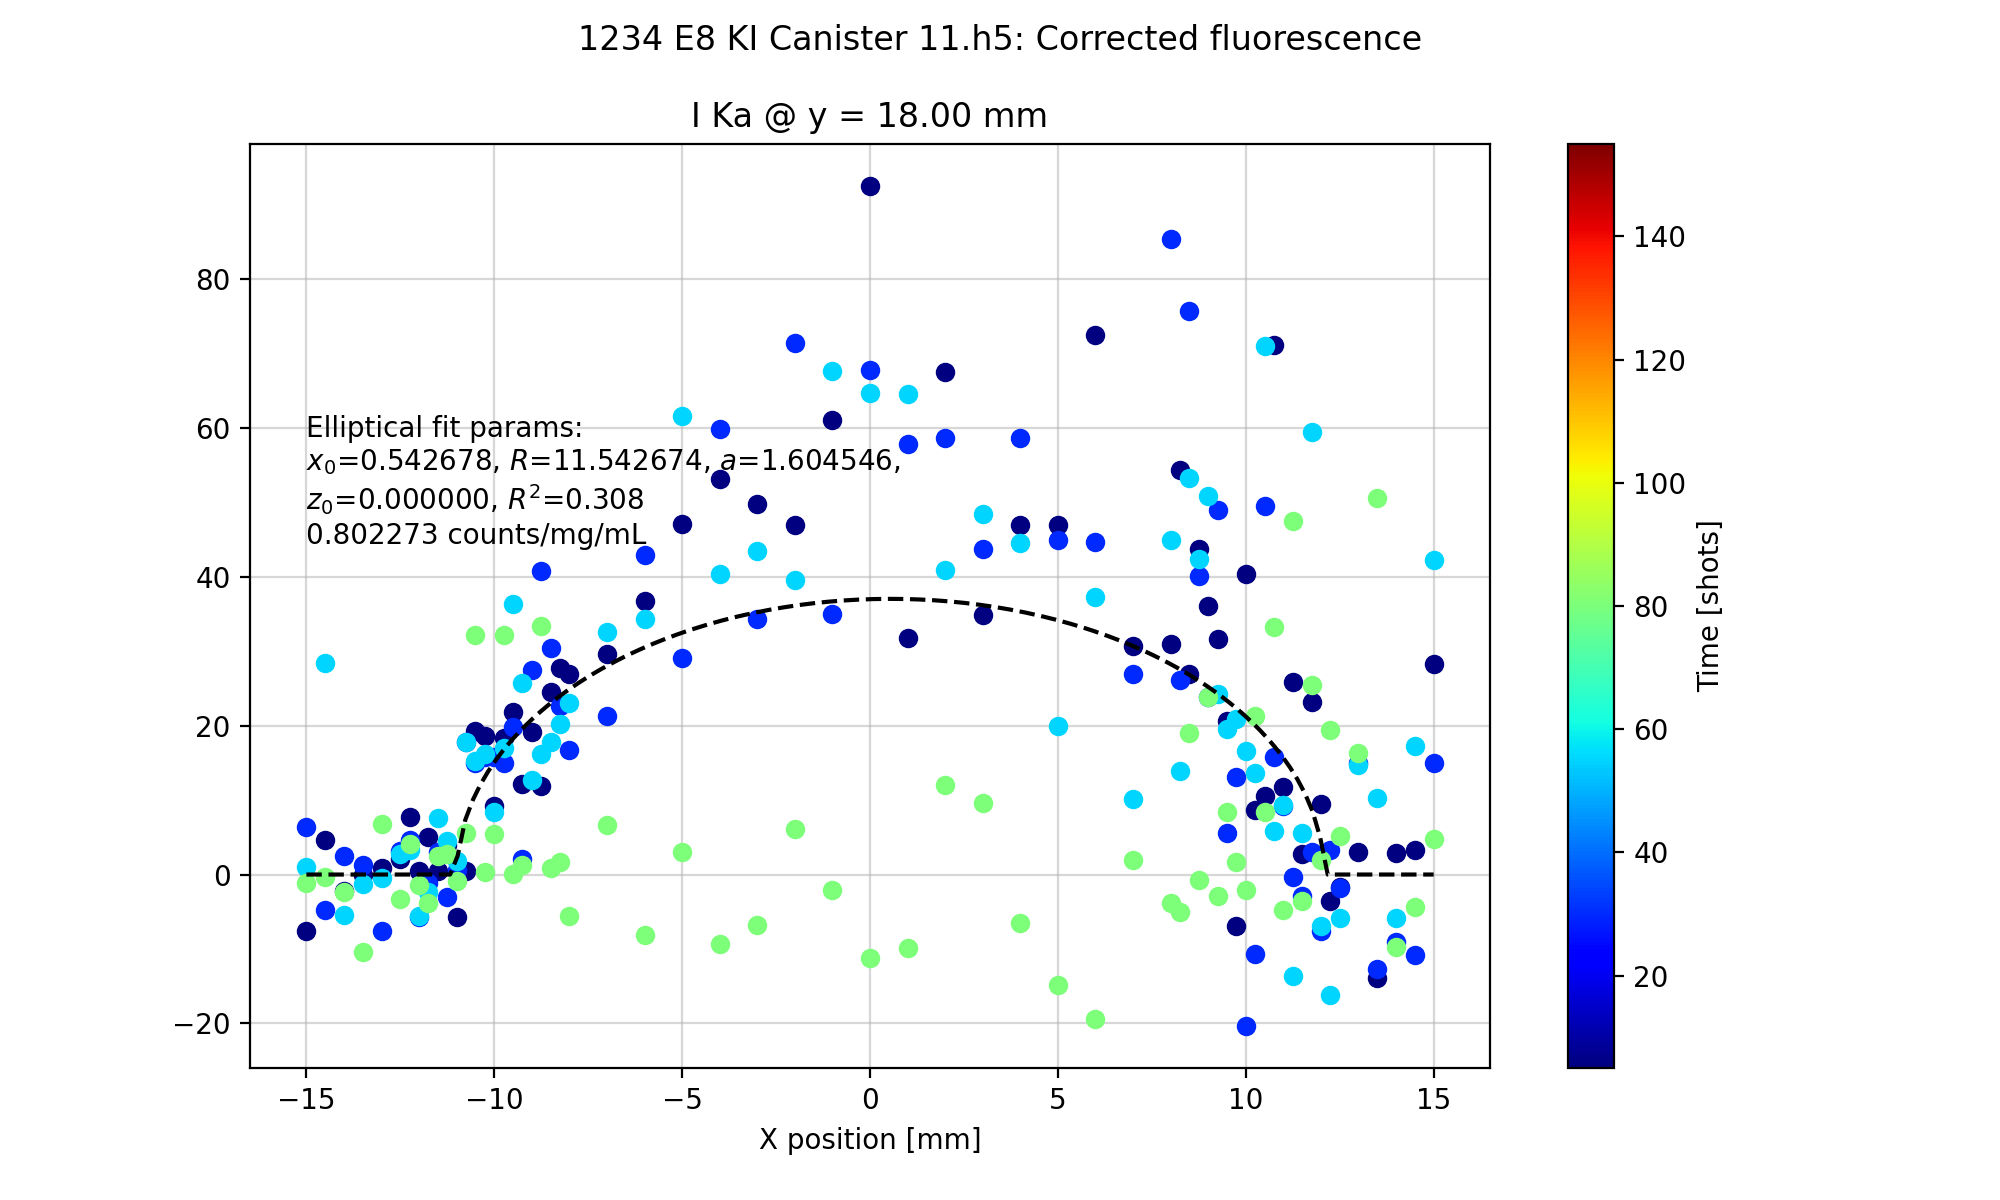

<IPython.core.display.Javascript object>


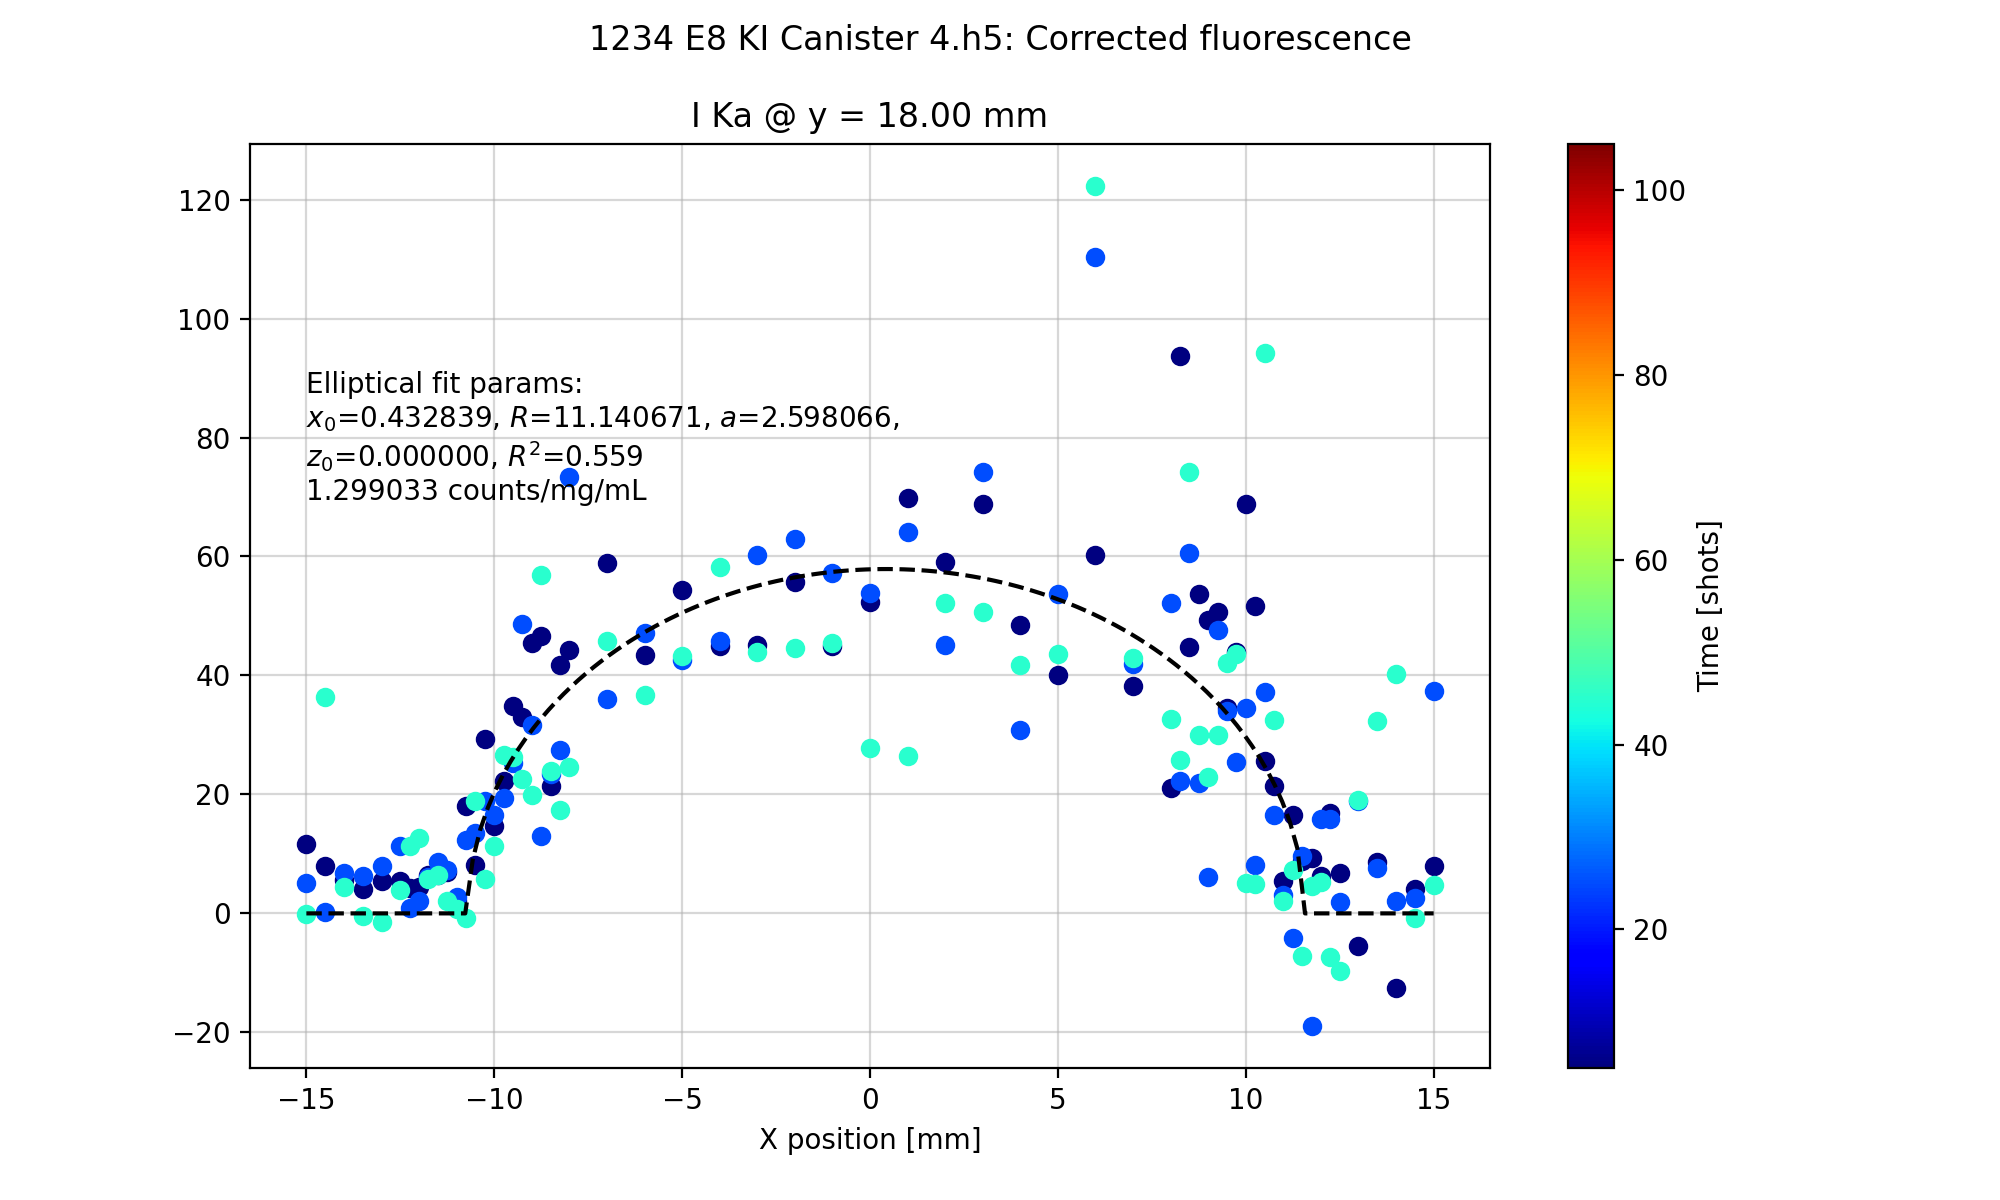

<IPython.core.display.Javascript object>


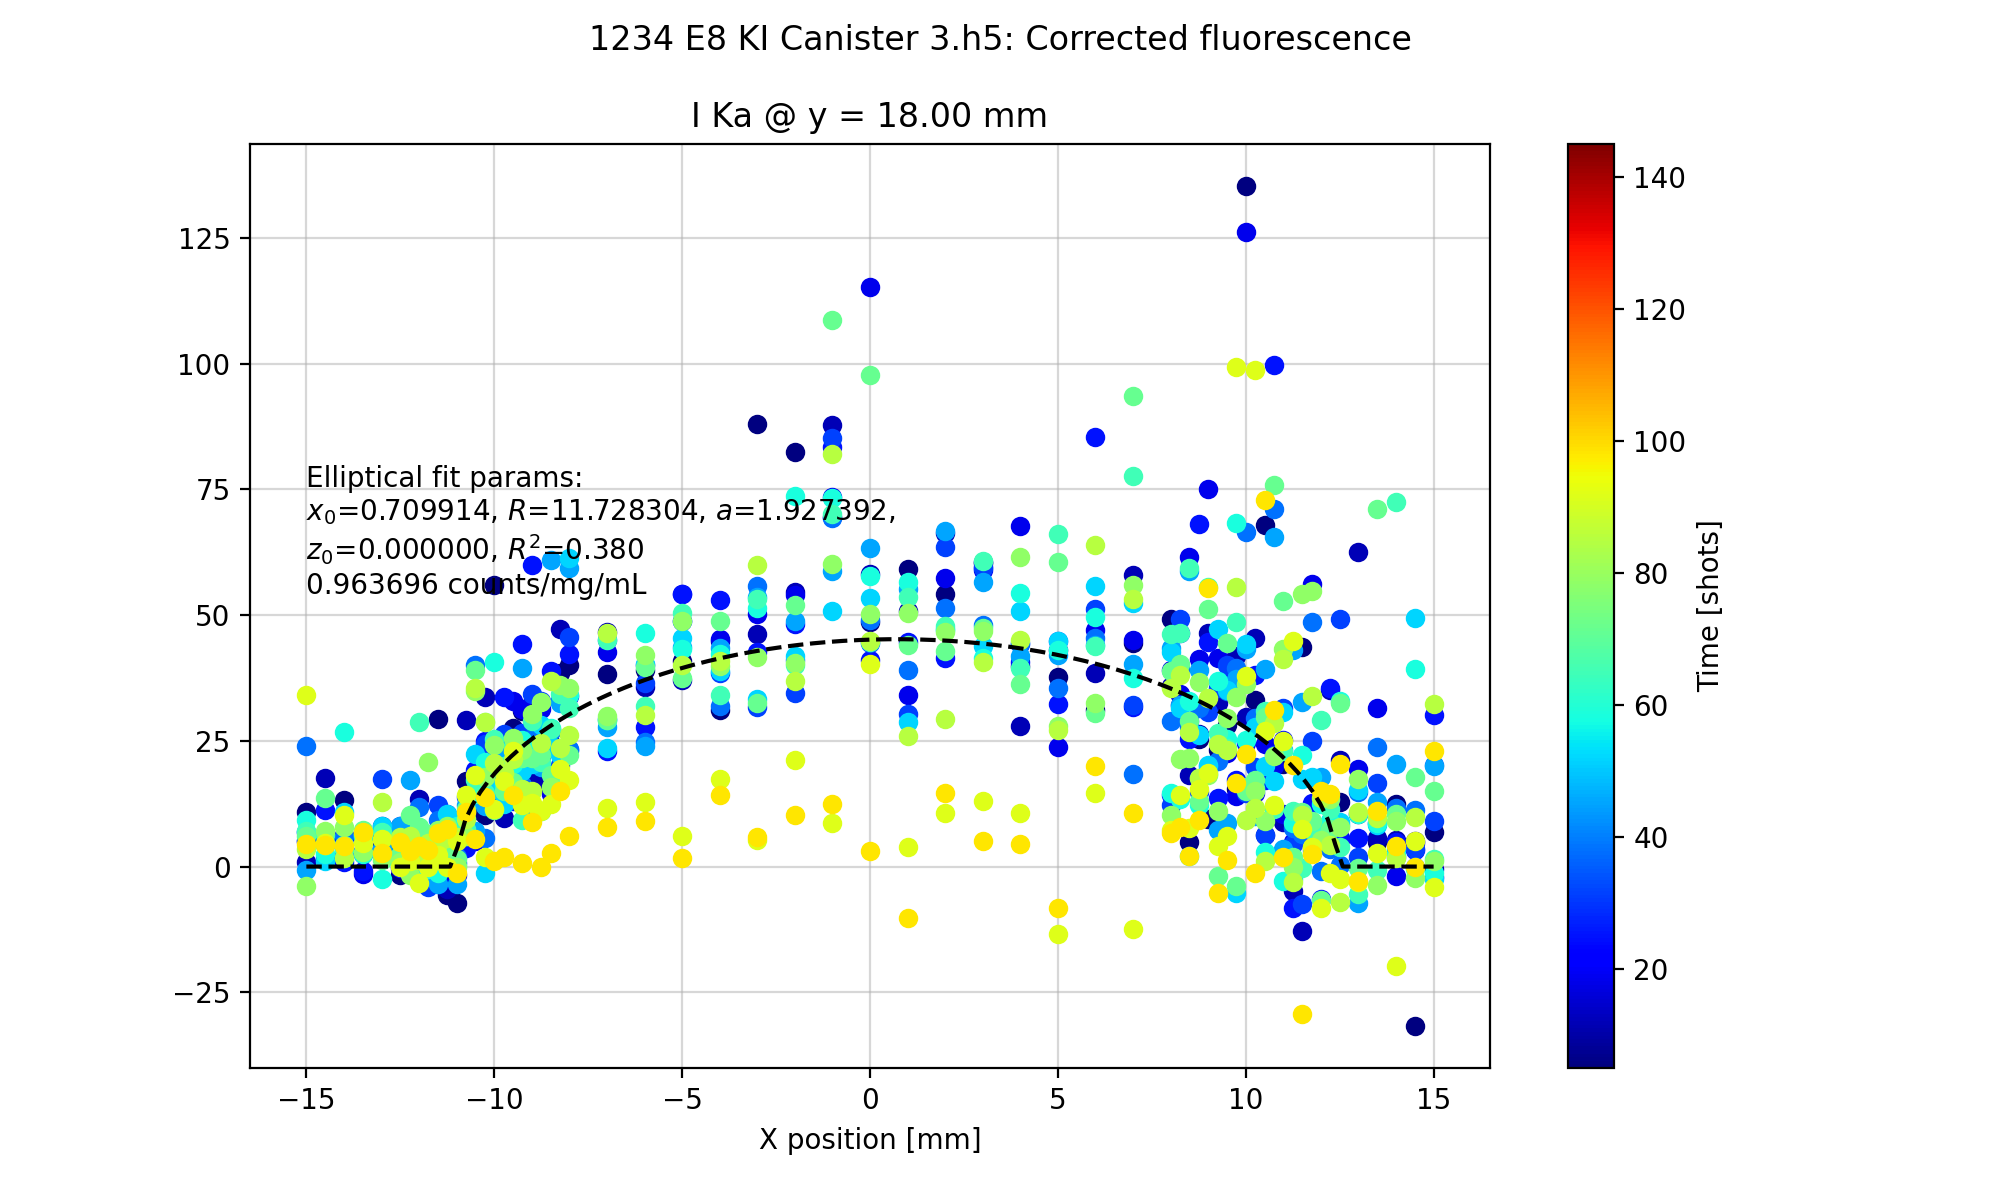

In [110]:
for filename,vPos,maxShots in zip(filenames,vPositions,maxShotsList):
    
    with h5py.File(filename,'r') as H:
        
        # Read data.
        x,y,t,zF = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/I Ka/integral'] )
        
        x,y,t,zP = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/pinDiode'] )

        x,y,t,I0 = readHorizontalScans( H['HorizontalScans/x'], H['HorizontalScans/y'],\
                                        H['HorizontalScans/shotCounter'],\
                                        H['HorizontalScans/diamondMonitor'] )

        
        # Calculations
        pinDiode = -np.log(zP/I0)        
        signalTrappingCorrection = applySignalTrapping(x,y,zF,zP,I0,propellant=propellant)
        zF_corr = zF / signalTrappingCorrection
        
        # Outlier masking
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                dz = np.diff(zF_corr[...,i,j]) 
                dz = np.hstack((0, dz))
                zF_corr[np.abs(dz)>35000,i,j] = np.nan # mask large sudden changes in level
    
    # y position for chosen profile
    i=vPos
    ym = np.nanmean(y[:,i,:])
    
    # Limit the time range so that the profile's not empty
    shotCounter = np.median(t[:,i,:],axis=0)
    timax = np.where(shotCounter>maxShots)[0][0] # stop after some number of shots
    
    # Fit elliptical profile to the data within the time range.
    fellipse = lambda x,x0,r,a,z0: a*secant(x-x0,r)
    xFit = x[:,i,:timax]; zFit = zF_corr[:,i,:timax]
    flt = ~np.isnan(xFit) & ~np.isnan(zFit) # Use non NaN points
    #flt = flt & (xFit<10)
    popt,pcov = scipy.optimize.curve_fit(fellipse,xFit[flt],zFit[flt],p0=(-3,1,1,0))
    r2 = calcR2(fellipse,xFit[flt],zFit[flt],popt)
    
    ################################################################
    fig=plt.figure(figsize=(10,6))
    plt.suptitle("%s: Corrected fluorescence" % filename)
    plt.title("I Ka @ y = %.2f mm" % yTransform(ym))
    plt.grid(alpha=.5)
    
    for j in np.arange(0,timax): # loop time for the first portion of the experiment
        plt.plot(x[:,i,j],zF_corr[:,i,j],marker='o',lw=0,c=plt.cm.jet(j/float(t.shape[2])))
        
    x_ = np.linspace(x[:,i,:timax].min(),x[:,i,:timax].max(),150)
    plt.plot(x_,fellipse(x_,*popt),ls='--',c='k')
    plt.text(-15,fellipse(x_,*popt).max()*1.2,\
     "Elliptical fit params:\n$x_0$=%f, $R$=%f, $a$=%f,\n$z_0$=%f, $R^2$=%.3f\n%f counts/mg/mL" % (popt[0],popt[1],popt[2],popt[3],r2,popt[2]/mgPermL))
        
    plt.xlabel('X position [mm]')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=t[:,i,:].min(), vmax=t[:,i,:timax].max()))
    plt.colorbar(sm,ax=plt.gca(),label='Time [shots]');

*Note cannot do this method for BaSO4 as those are vertical scans - will need to use initial values at 1st shot instead.*